# Extract the Statistics for the different scoring functions for each TF

In [93]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "Su(H)", "Trl"]

score_key = ['energy', 'gomer','sumlog', 'sumoc','maxoc', 'ama', 'maxlog']
stats = ['spearman', "auc", "mncp", "pearson"]
for stat in stats:
    if stat == "auc":
        idx = 1
    elif stat == "mncp":
        idx = 2
    elif stat == "pearson":
        idx = 3
    elif stat == 'spearman':
        idx = 4
    else:
        continue
    for tf in tf_list:
        tf2 = tf.replace("(","").replace(")","")
        results_path = "Results/"+ tf2 
        raw_data = []
        raw_data.append(["Motif"])
        flag = 0
        for key in score_key:
            i = 1
            raw_data[0].append(key)
            with open('%s/%s.%s' % (results_path,tf2,key), "r") as score_out:
                for line in score_out:
                    if line.split()[1]=="AUC":
                        continue
                    else:
                        if flag ==0:
                            raw_data.append([line.split()[0]])
                            raw_data[i].append(line.split()[idx])
                            i+=1
                        else:
                            raw_data[i].append(line.split()[idx])
                            i+=1
                flag = 1

            with open("%s/%s_%s.rawscores" %(results_path,tf2, stat), 'w') as raw_out:
                for row in raw_data:
                    raw_out.writelines('\t'.join(map(str, row)) + '\n')



# Specific ChIP-seq peak file correlation 

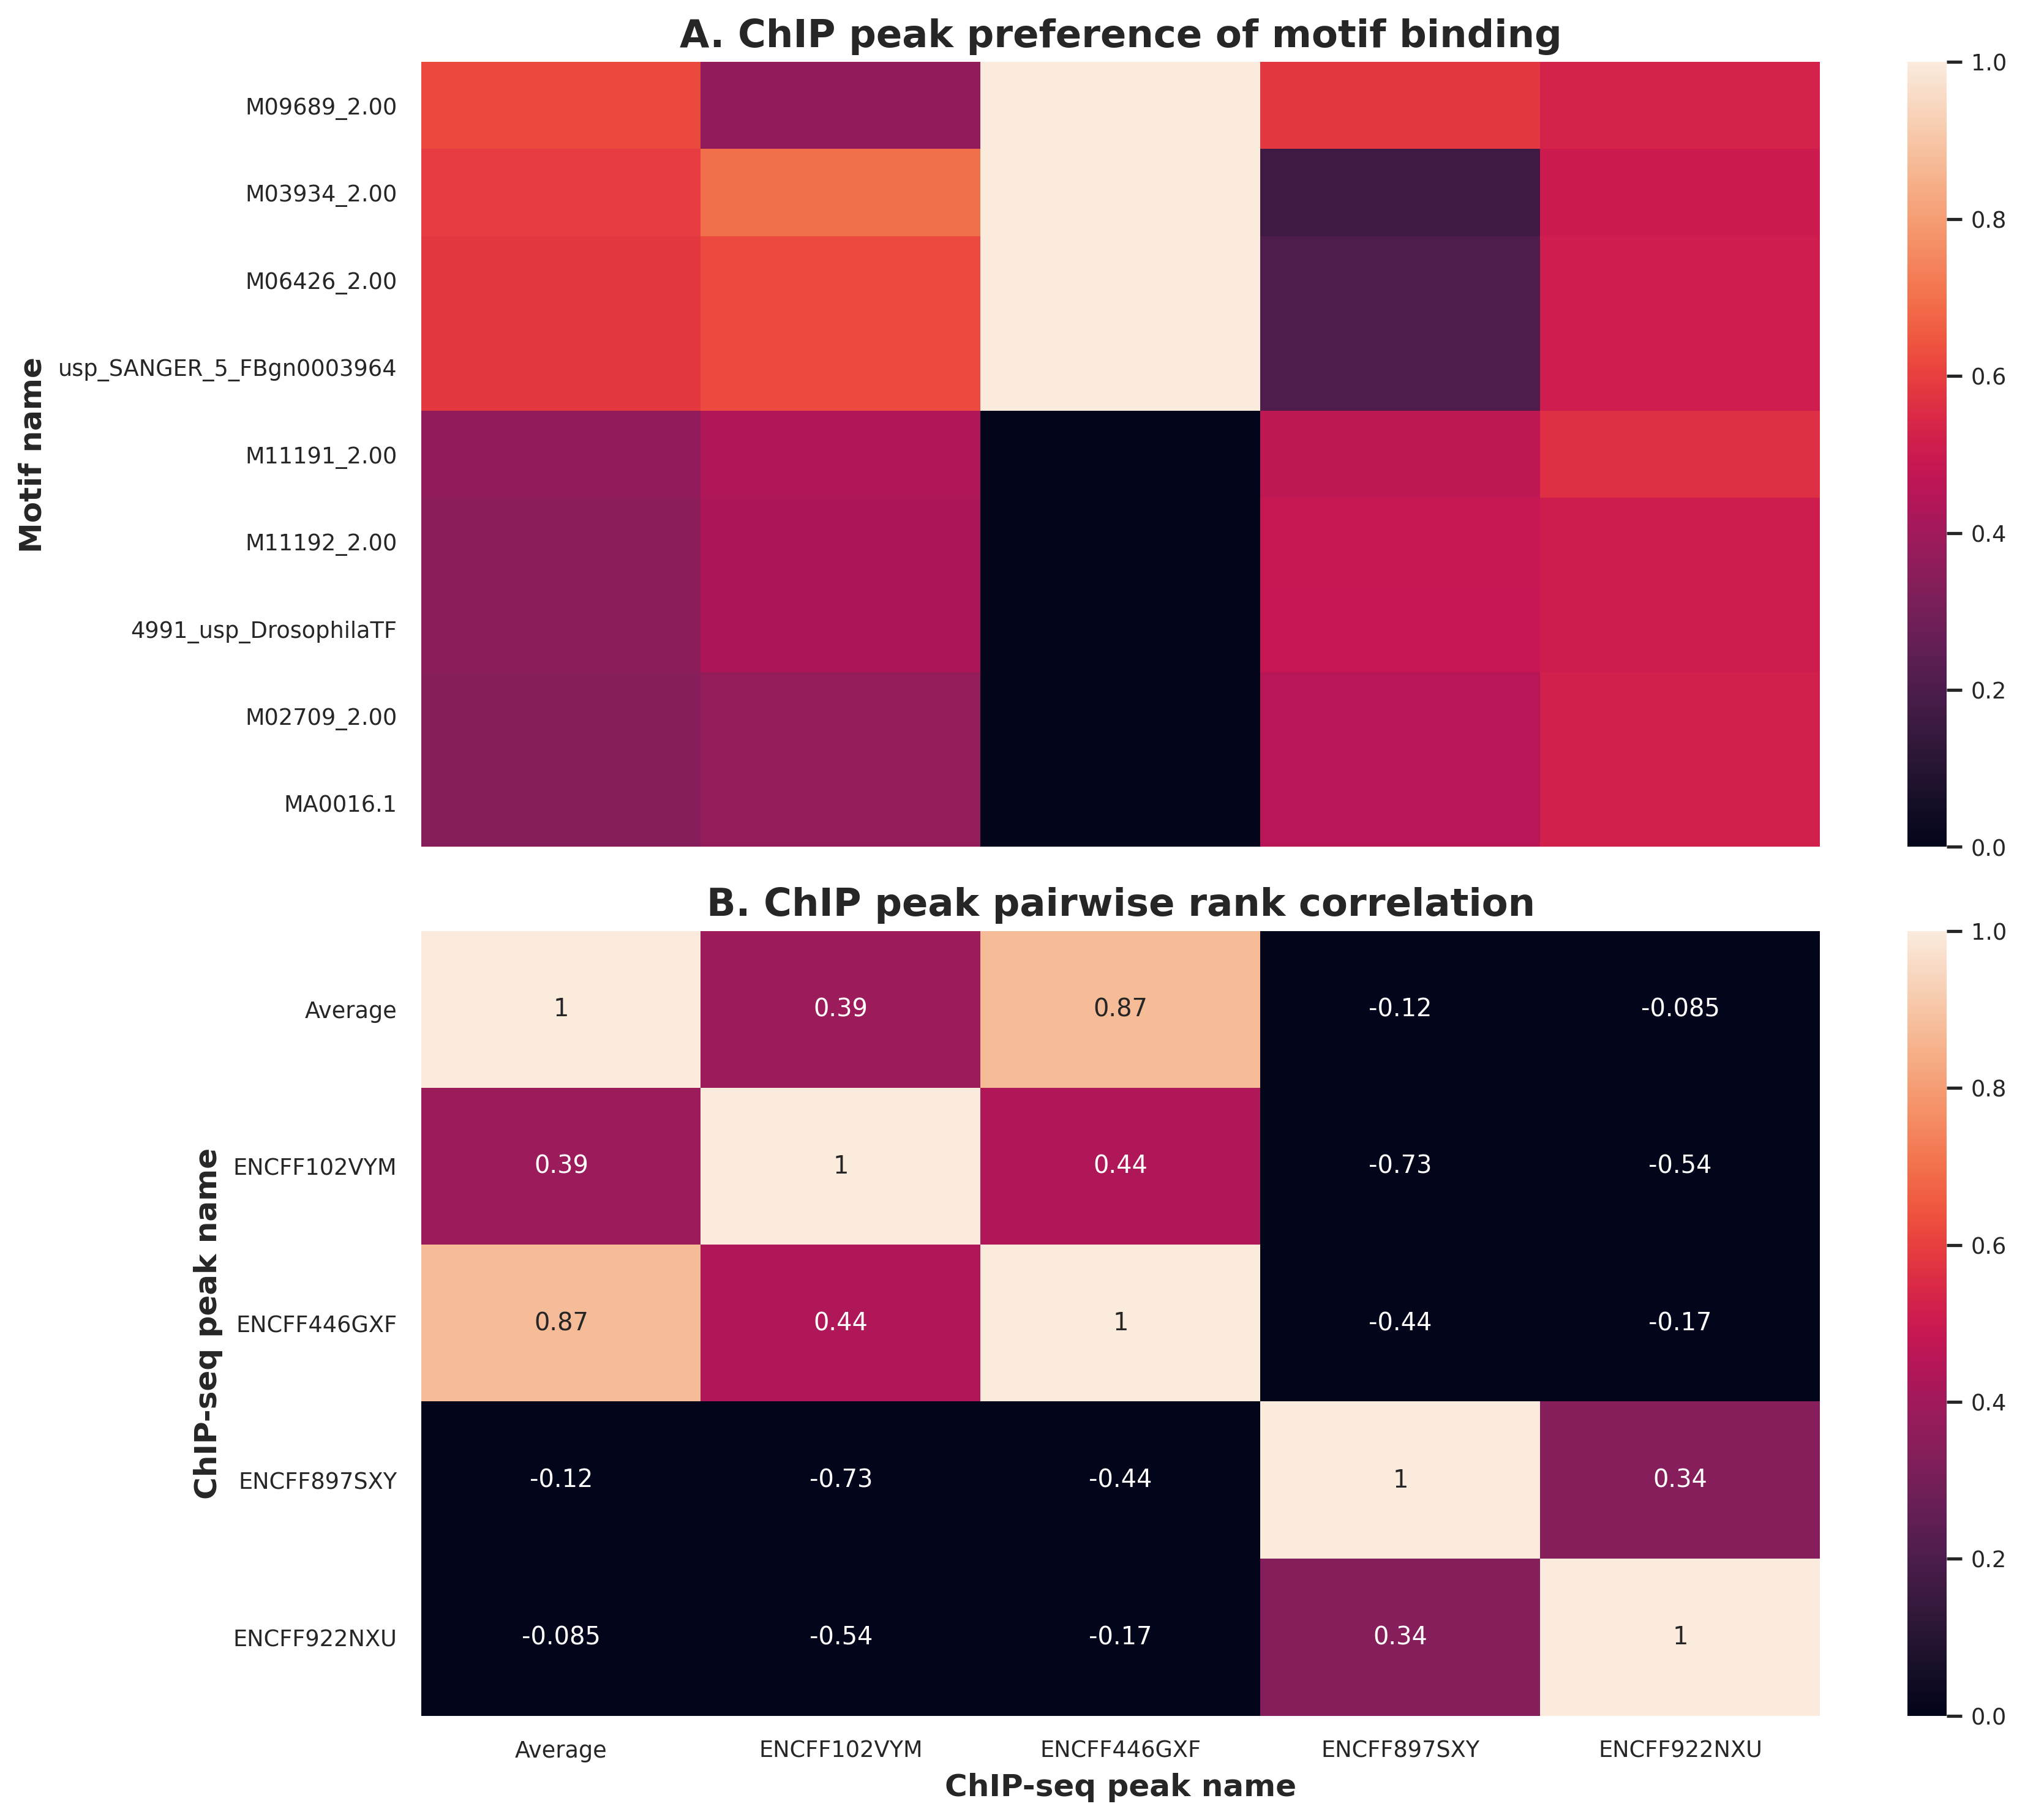

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_raw_assess(raw_data, figure_output, stat):
    """
    This function allows the raw data to be plotted  in the form of a heatmap.
    
    This way, information about how each motif scores in different cell lines is
    obtained
    """
    #Increase the font
#     fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 13), sharex=True, sharey=False)
    sns.set(font_scale=0.8)
    fig = plt.figure(figsize=(12, 10),dpi=300)
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    #sns.set_style("white")
    raw_max = pd.read_table(raw_data)
    raw_max = raw_max.drop_duplicates()
    
    raw_edit = raw_max.pivot('Motif', 'ChIP_file', stat)
    raw_edit.sort_values(by="Average", axis=0, ascending=False, inplace=True)
    #fig, ax = plt.subplots()
    ax1.set_title('A. ChIP peak preference of motif binding',fontdict={'fontsize': 15, 'fontweight':'semibold','ma':'center'})
    ax2.set_title('B. ChIP peak pairwise rank correlation', fontdict={'fontsize': 15, 'fontweight':'semibold','ma':'center'})
    # the size of A4 paper
    sns.heatmap(raw_edit, vmin=0, vmax=1, annot=False,xticklabels=False, ax = ax1)
    sns.heatmap(raw_edit.corr(method='spearman'),vmin=0, vmax=1, ax = ax2, annot=True)
    ax1.set_xlabel("")
    ax1.set_ylabel("Motif name",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    ax2.set_xlabel("ChIP-seq peak name",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    ax2.set_ylabel("ChIP-seq peak name",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    fig.tight_layout()
    f = plt.gcf()
    f.savefig(figure_output, bbox_inches='tight')
    return raw_edit

tf = "usp"
raw_edit = plot_raw_assess("Results/%s/%s_raw.gomer" %(tf,tf), 
                           'Results/%s/%s_specific_gomer.png'%(tf,tf), 'AUC')

In [50]:
import pandas as pd
?plt.plot

Signature: plt.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], *, data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y,

# Effect of statistics on motif ranking

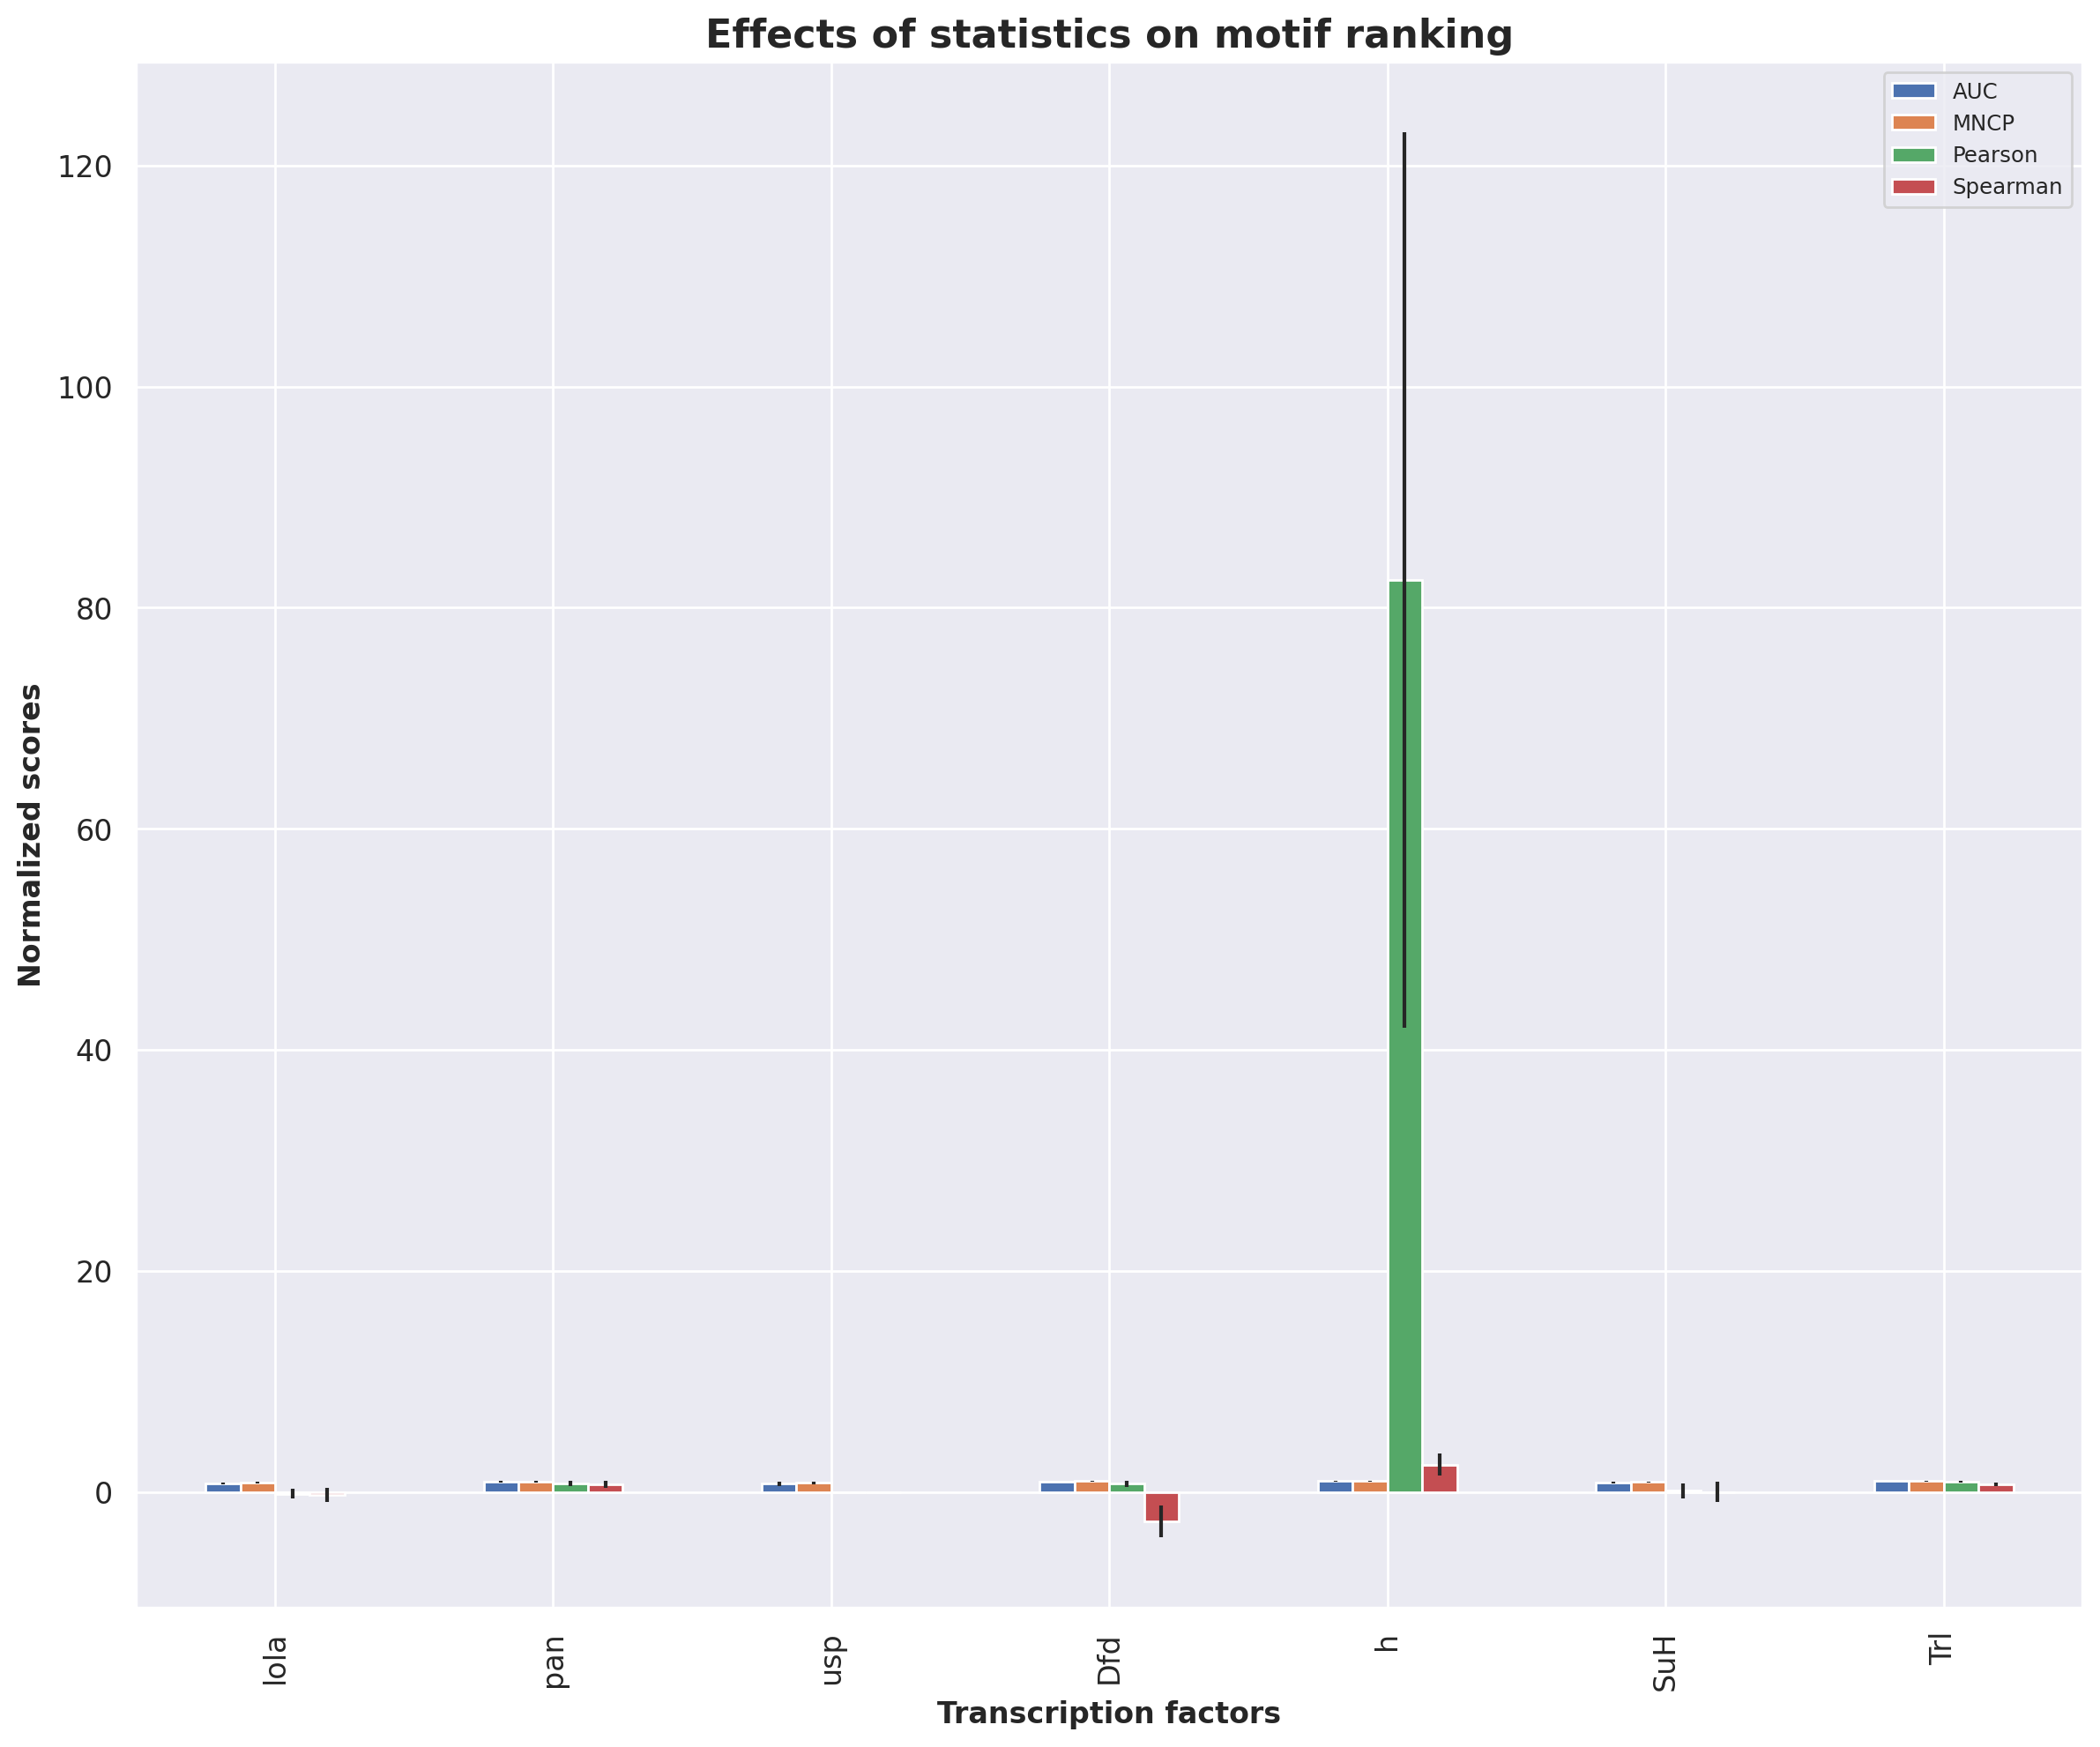

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ranksums
score = 'gomer'
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]

tf = tf_list[0]
chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
chip = chip/chip.max()
chip_std = chip.std().to_frame(name=tf).T
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T
rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

for tf in tf_list[1:]:
    chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    #print tf
    rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    
    chip_mean_test = chip_mean_test.append(chip_mean.T)

fig = plt.figure(dpi=200)
ax = fig.add_subplot()

chip_mean_test.plot(kind='bar',yerr=chip_std, ax= ax,fontsize=12, figsize=(12,10))
#ax.grid(False)
ax.set_title("Effects of statistics on motif ranking",fontdict={'fontsize': 16, 'fontweight': 'bold'} )
ax.set_xlabel("Transcription factors",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
ax.set_ylabel("Normalized scores", fontdict={'fontsize': 12, 'fontweight': 'semibold'})
#ax.set_axis_bgcolor('W')
fig.tight_layout()
#fig = ax.get_figure()

#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')




We tested the effect of the statistics on the gomer motif scoring function and there was a spike in pearson correlation in the h transcription factor. This forced us to run the effect of the statistics on all the different function to find which scoring function works optimumly with the Drosophila data. Sumlog and maxlog scoring function perform well across all transcription factors.

/home/festo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


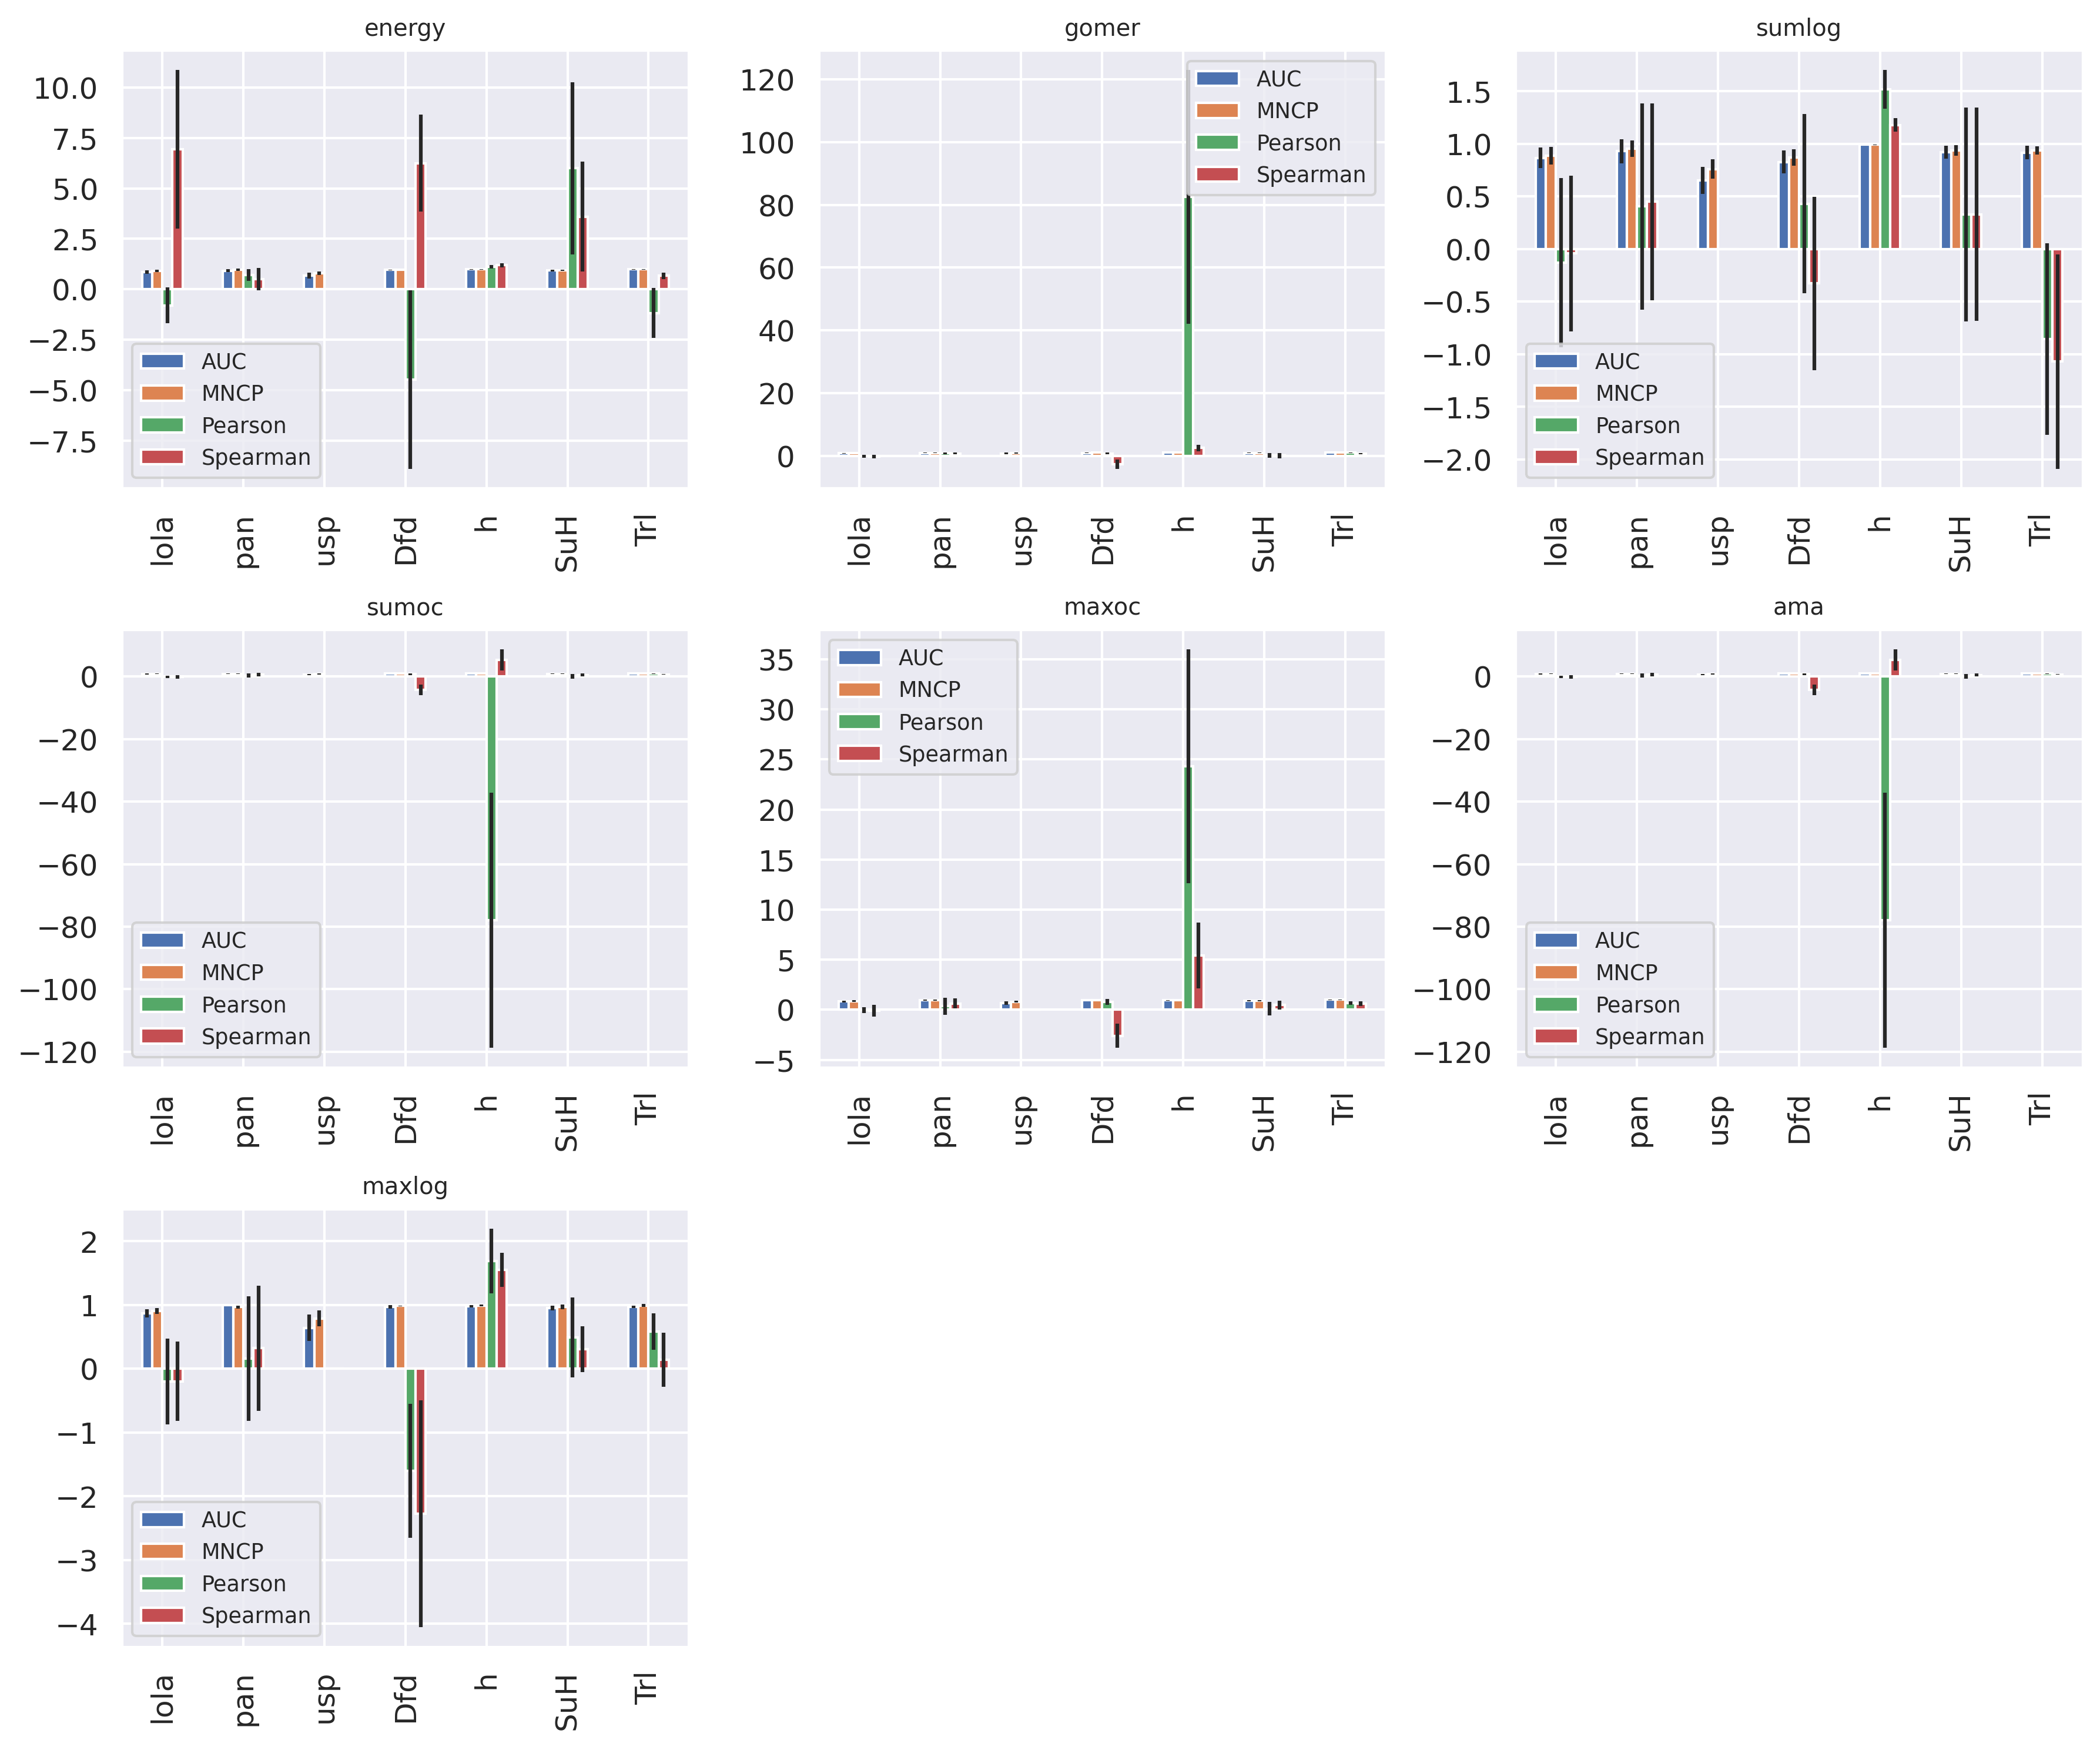

In [88]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
score_list = ["energy", "gomer", "sumlog", "sumoc",	"maxoc", "ama", "maxlog"]

fig = plt.figure(figsize=(12,10),dpi=300)
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)

for c,score in enumerate(score_list):
    #print(f"Effects of statistics on motif ranking using {score} scoring")
    c +=1
    tf = tf_list[0]
    chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    chip_std = chip.std().to_frame(name=tf).T
    chip_mean = np.mean(chip).to_frame(name=tf)
    chip_mean_test = chip_mean.T
    rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

    for tf in tf_list[1:]:
        chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
        chip = chip/chip.max()
        #print tf
        rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
        chip_s = chip.std().to_frame(name=tf)
        chip_std = chip_std.append(chip_s.T)
        chip_mean = np.mean(chip).to_frame(name=tf)

        chip_mean_test = chip_mean_test.append(chip_mean.T)

    ax = fig.add_subplot(3,3,c)
    chip_mean_test.plot(kind='bar',yerr=chip_std, figsize=(12,10),
                             title=(f"{score}"), fontsize=12, ax = ax)
    #ax.grid(False)
fig.tight_layout()
#     ax.set_xlabel("Transcription factors")
#     ax.set_ylabel("Normalized scores")
#     #ax.set_axis_bgcolor('W')
#     fig = ax.get_figure()


## View individual large plots

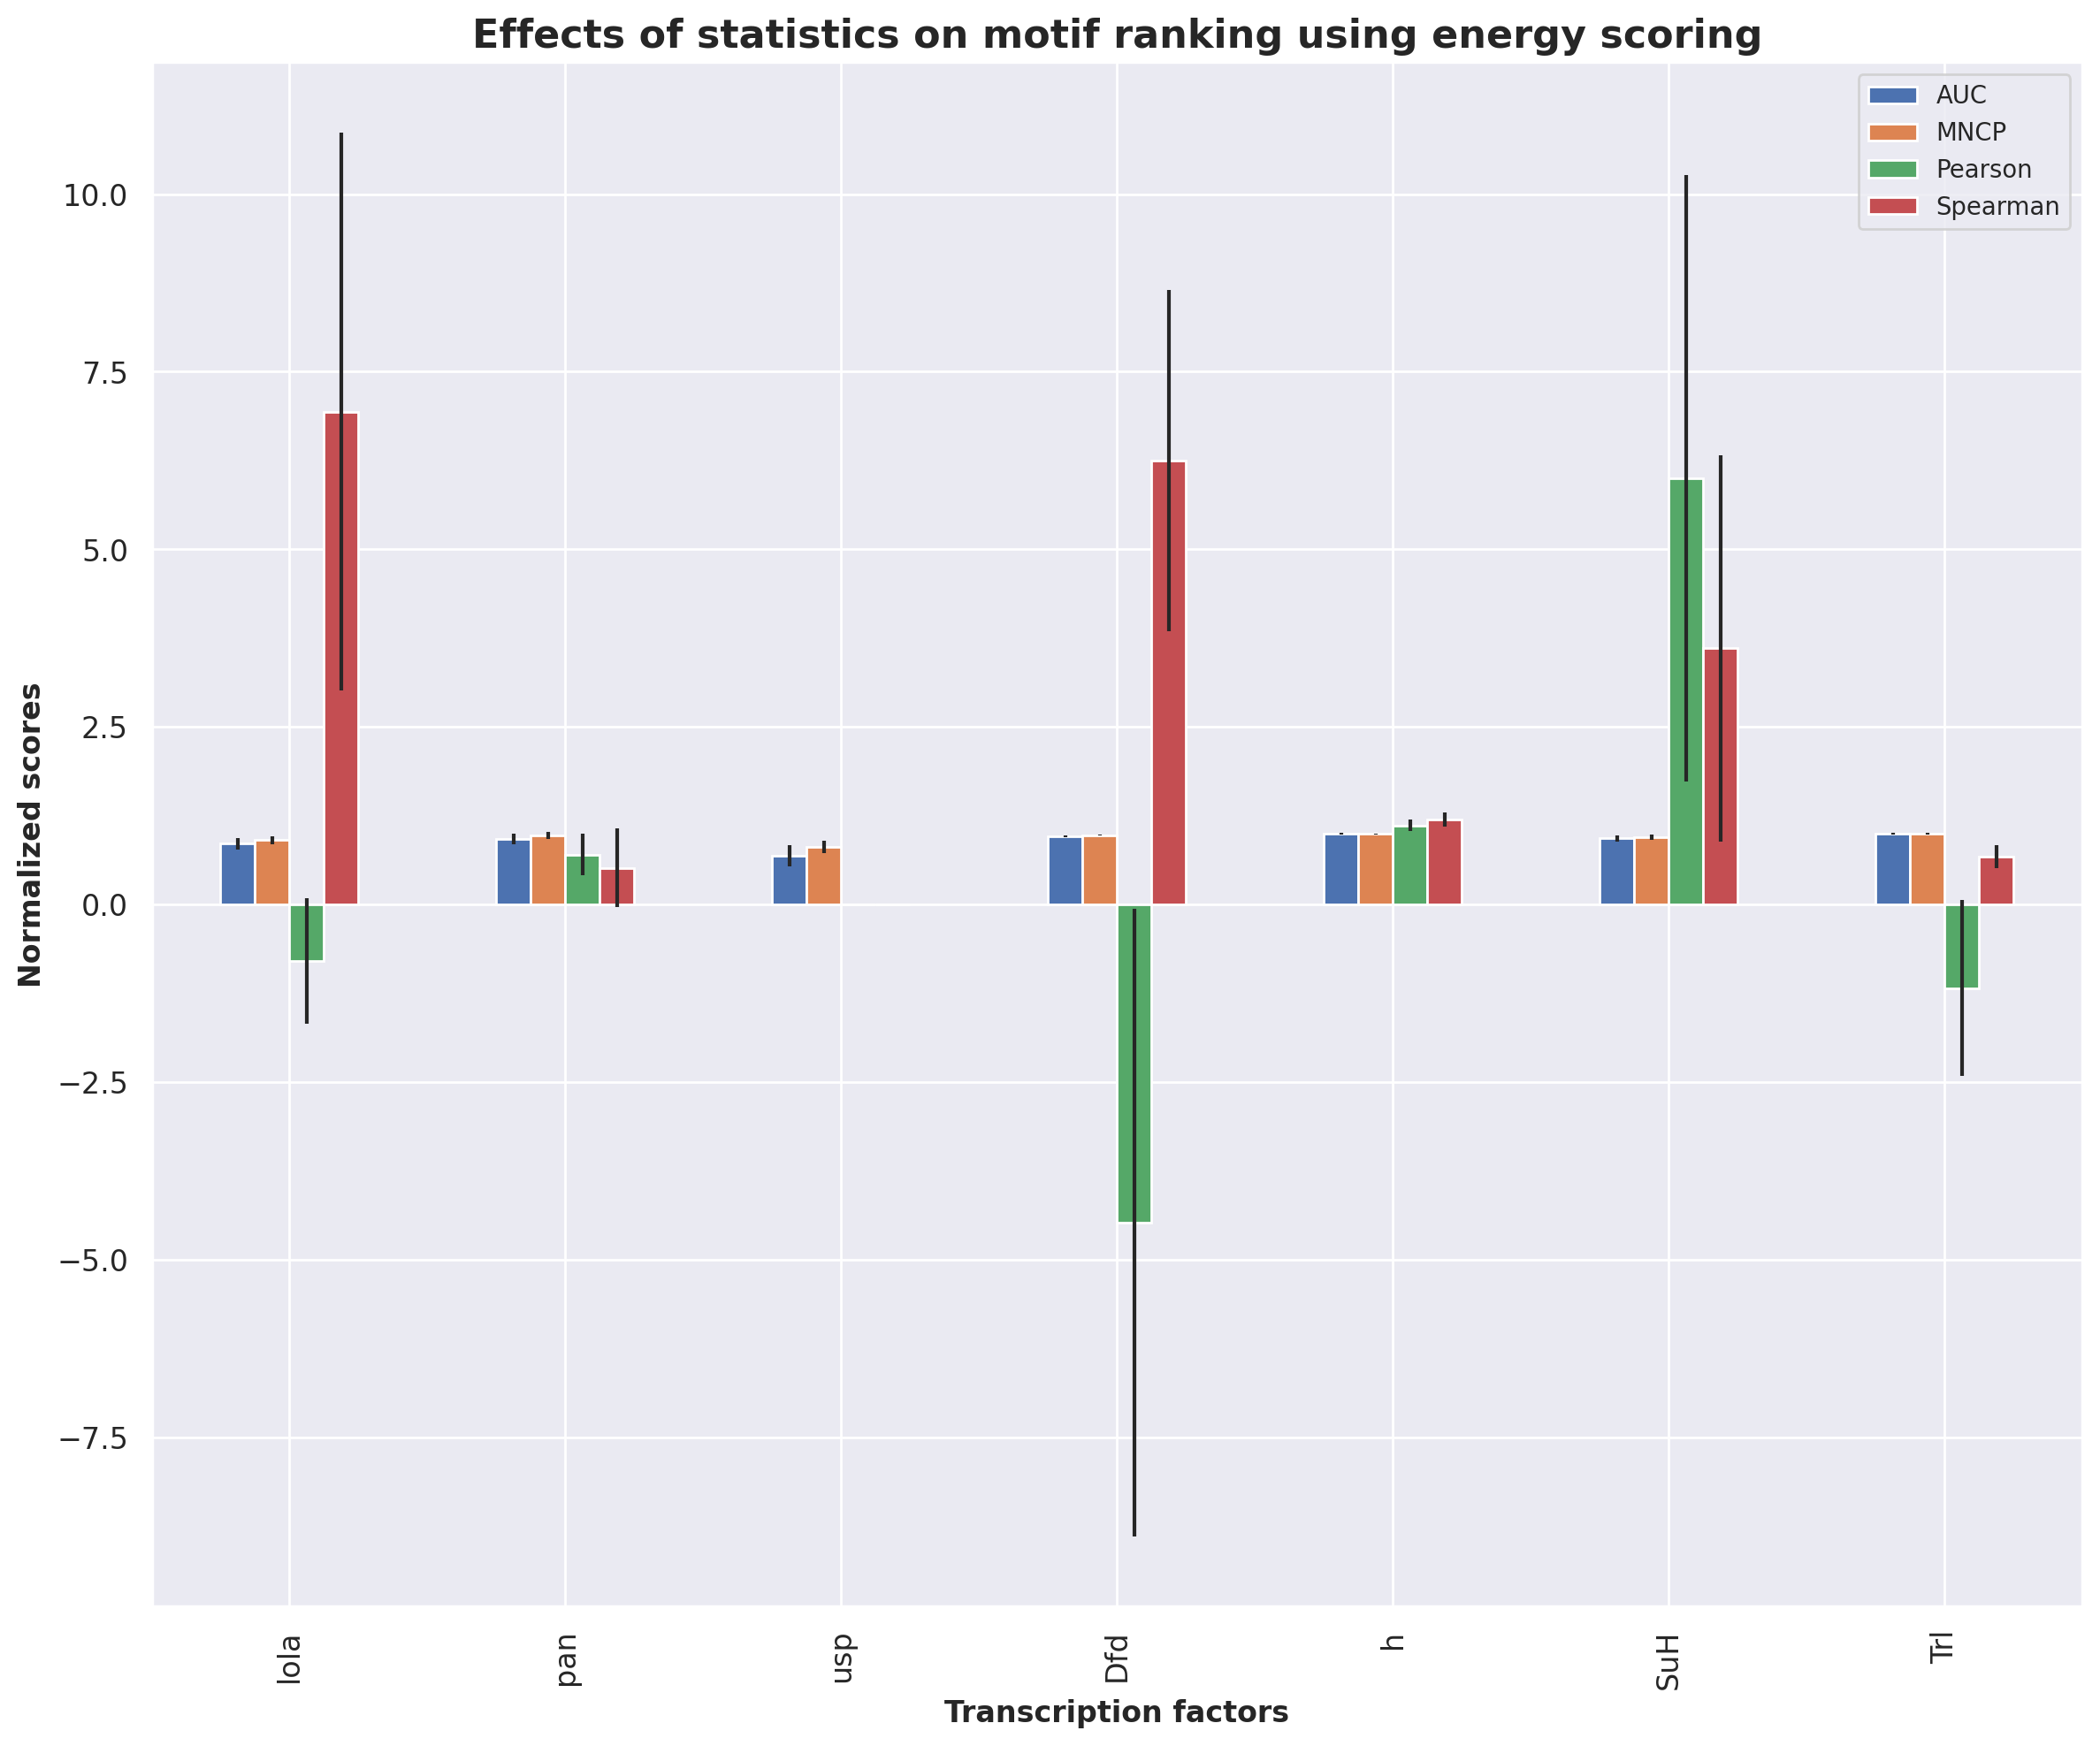

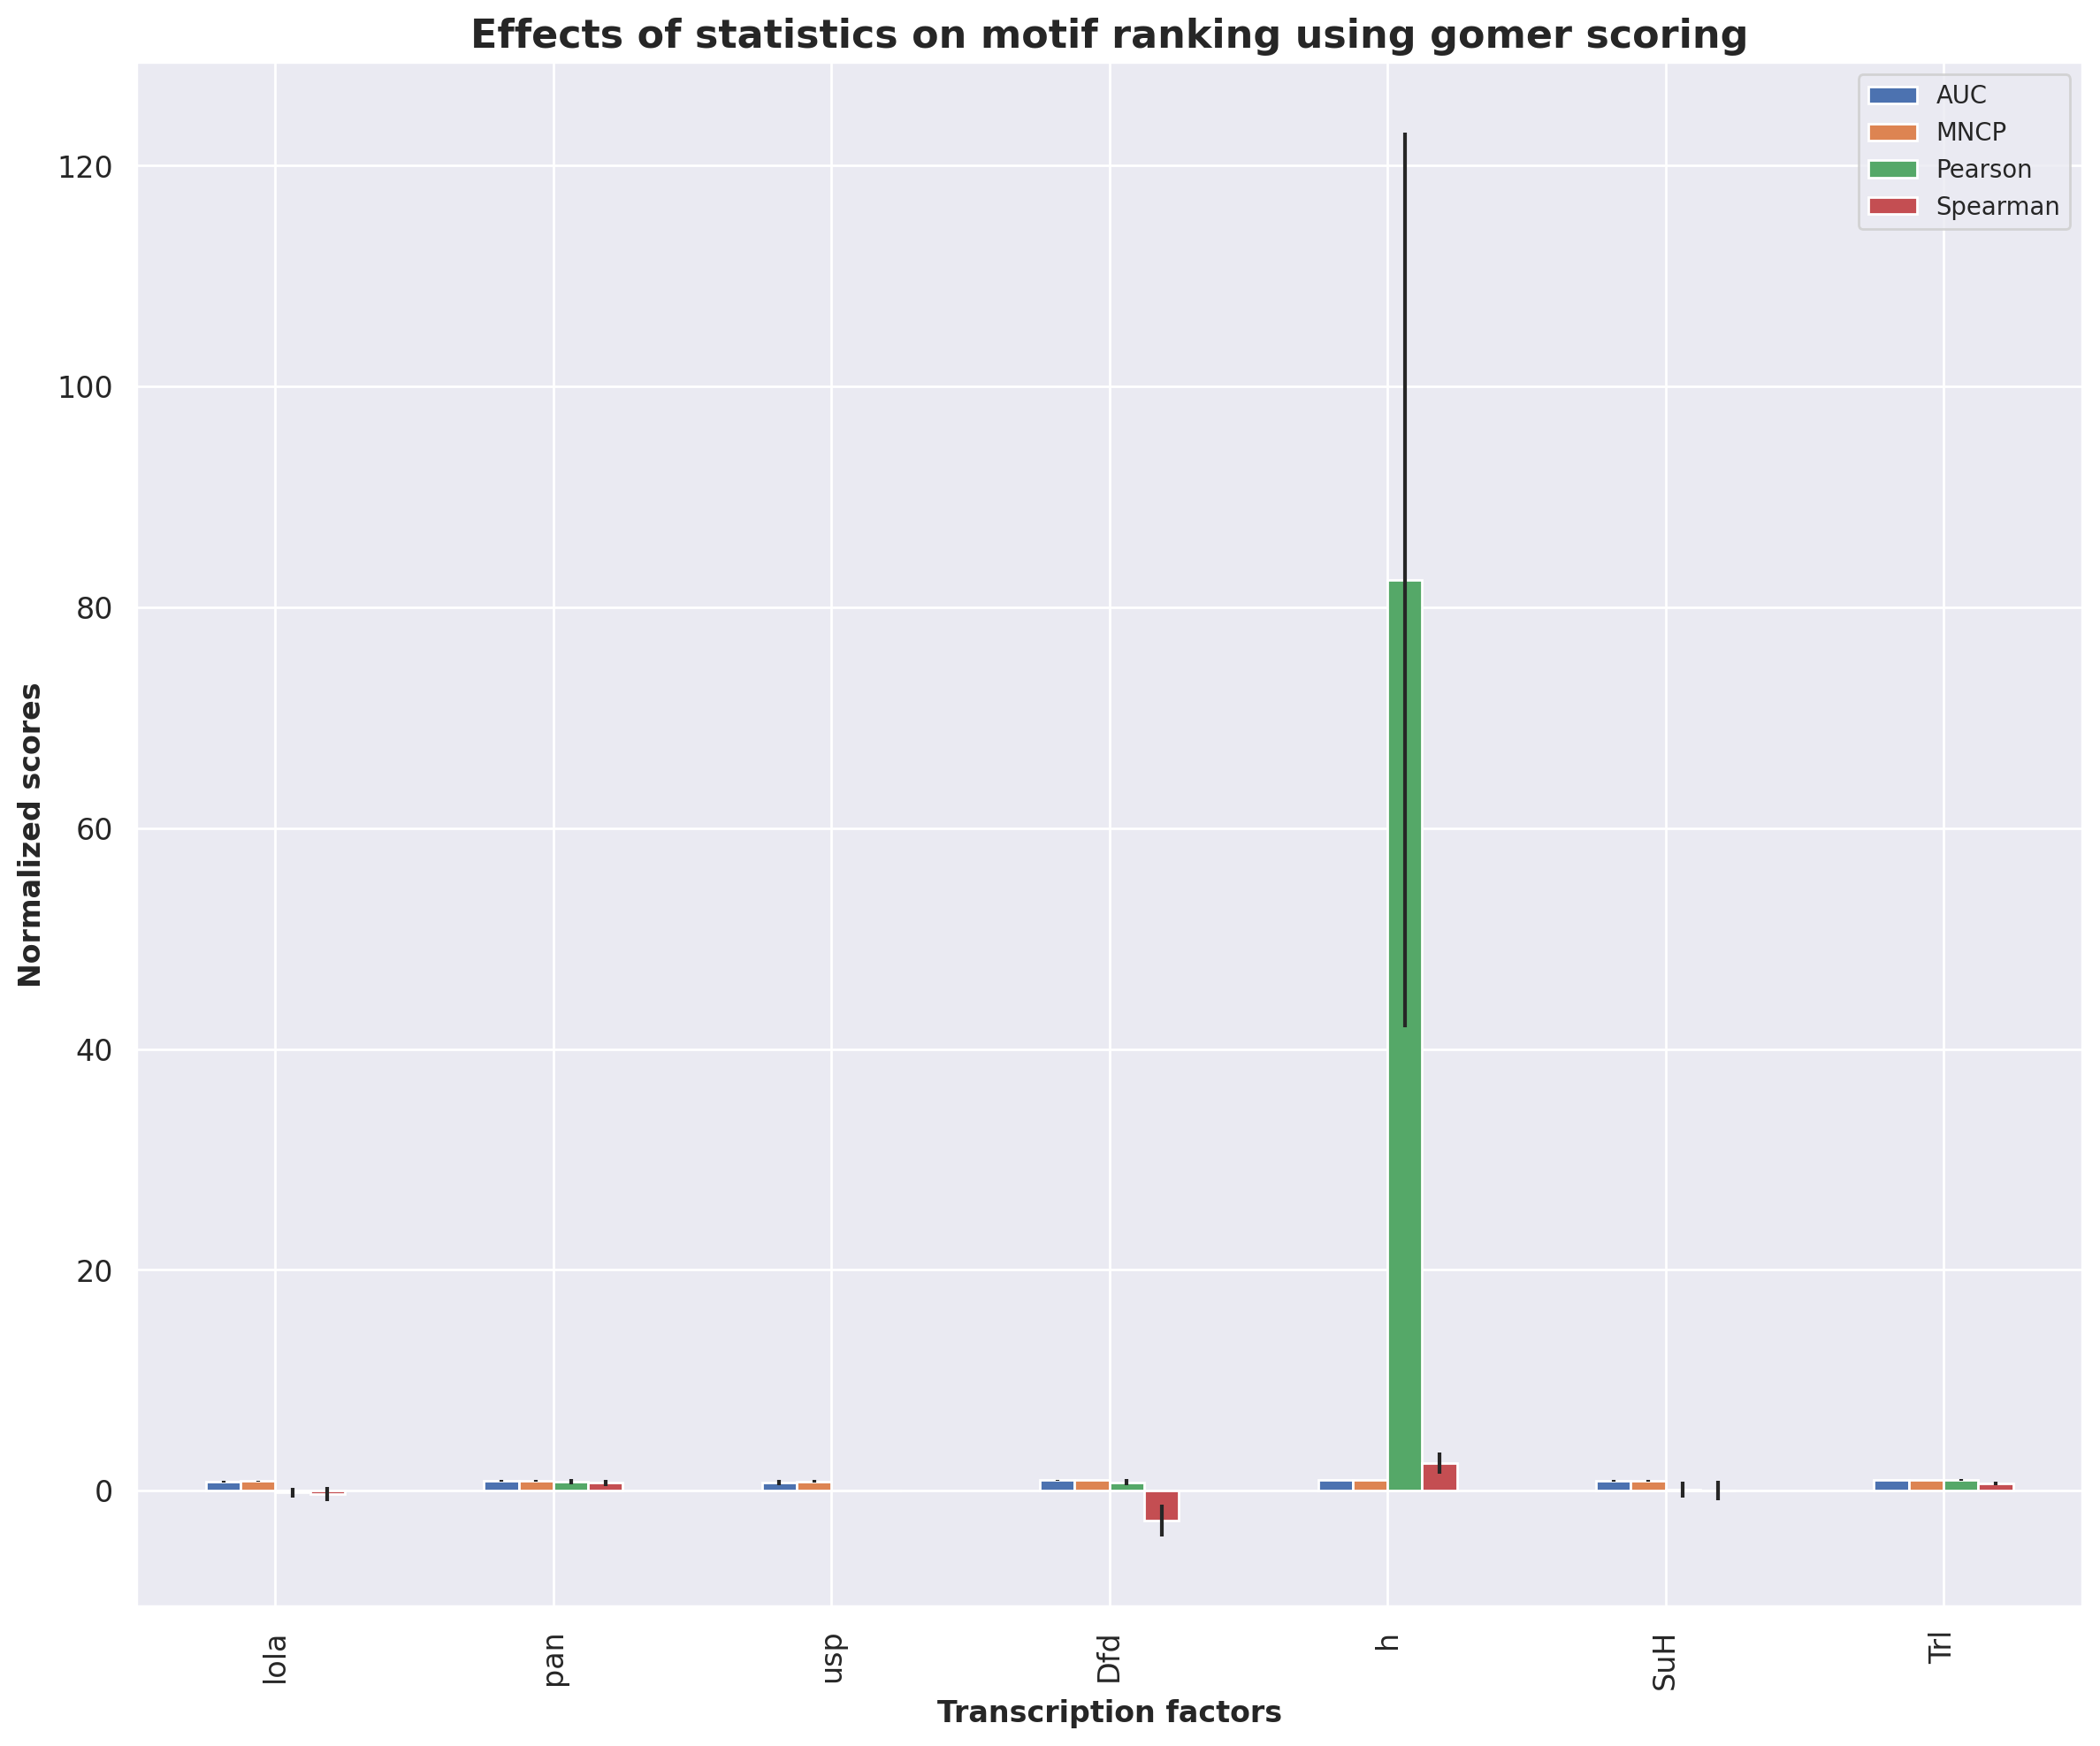

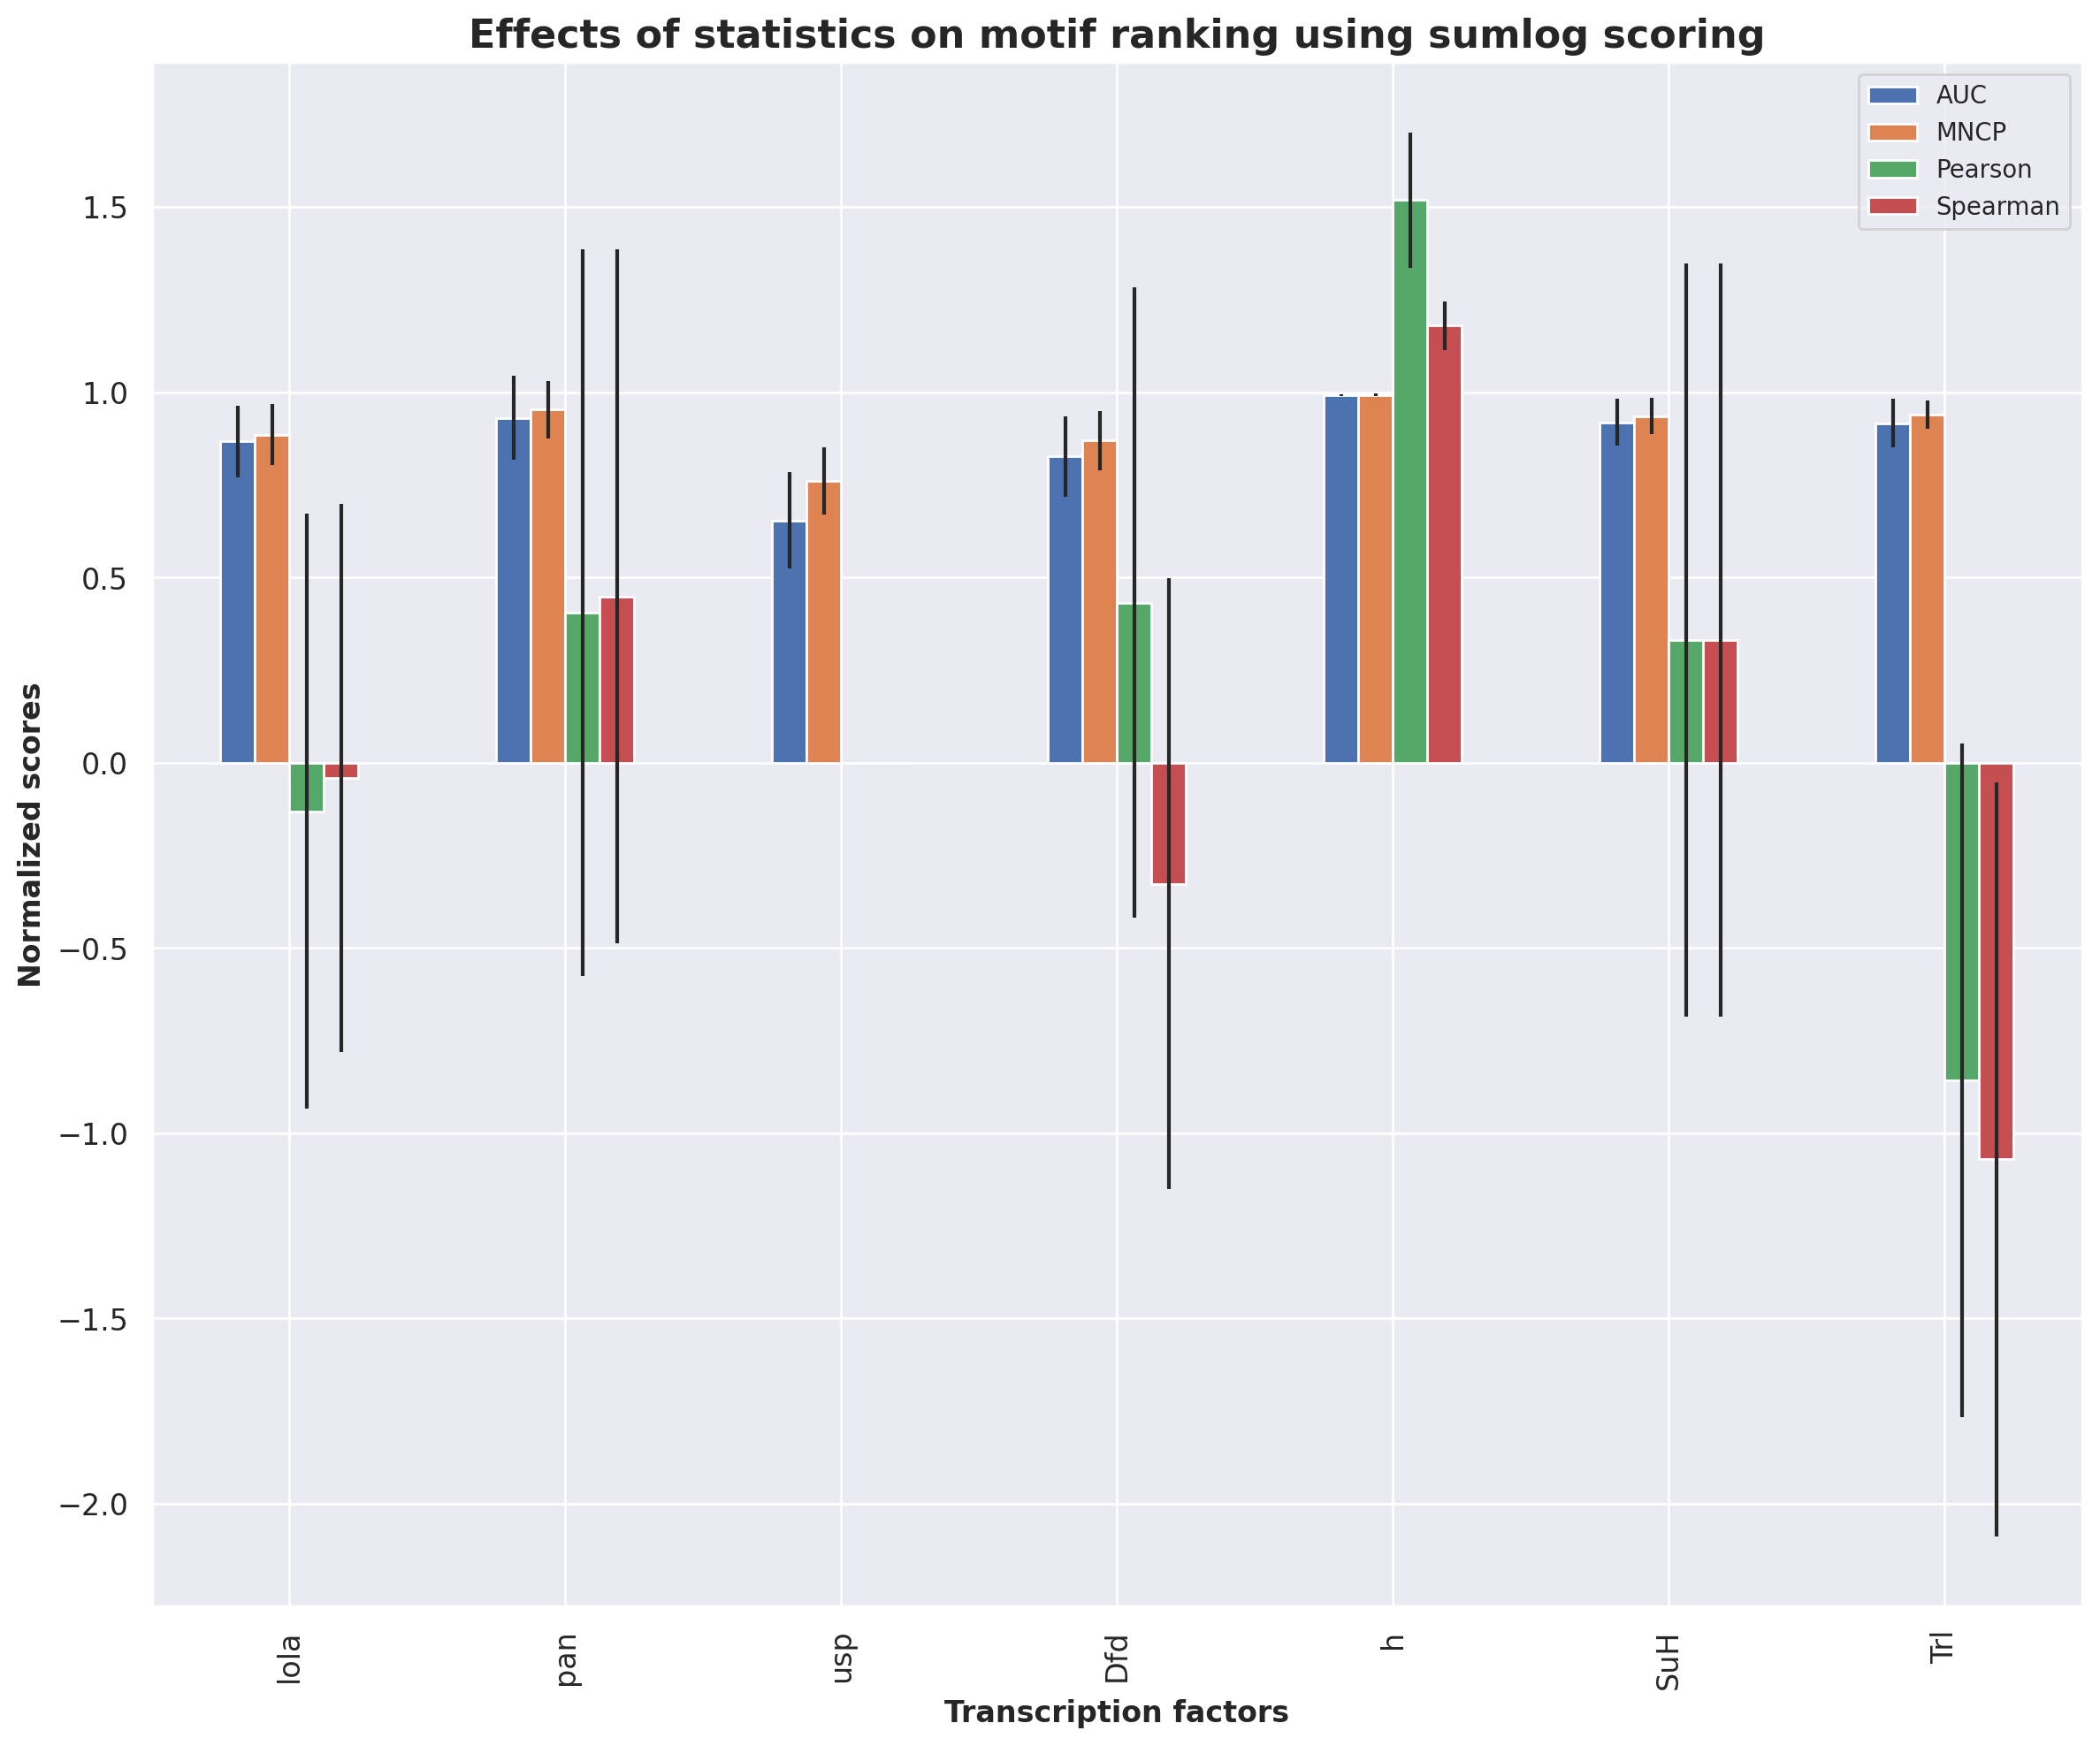

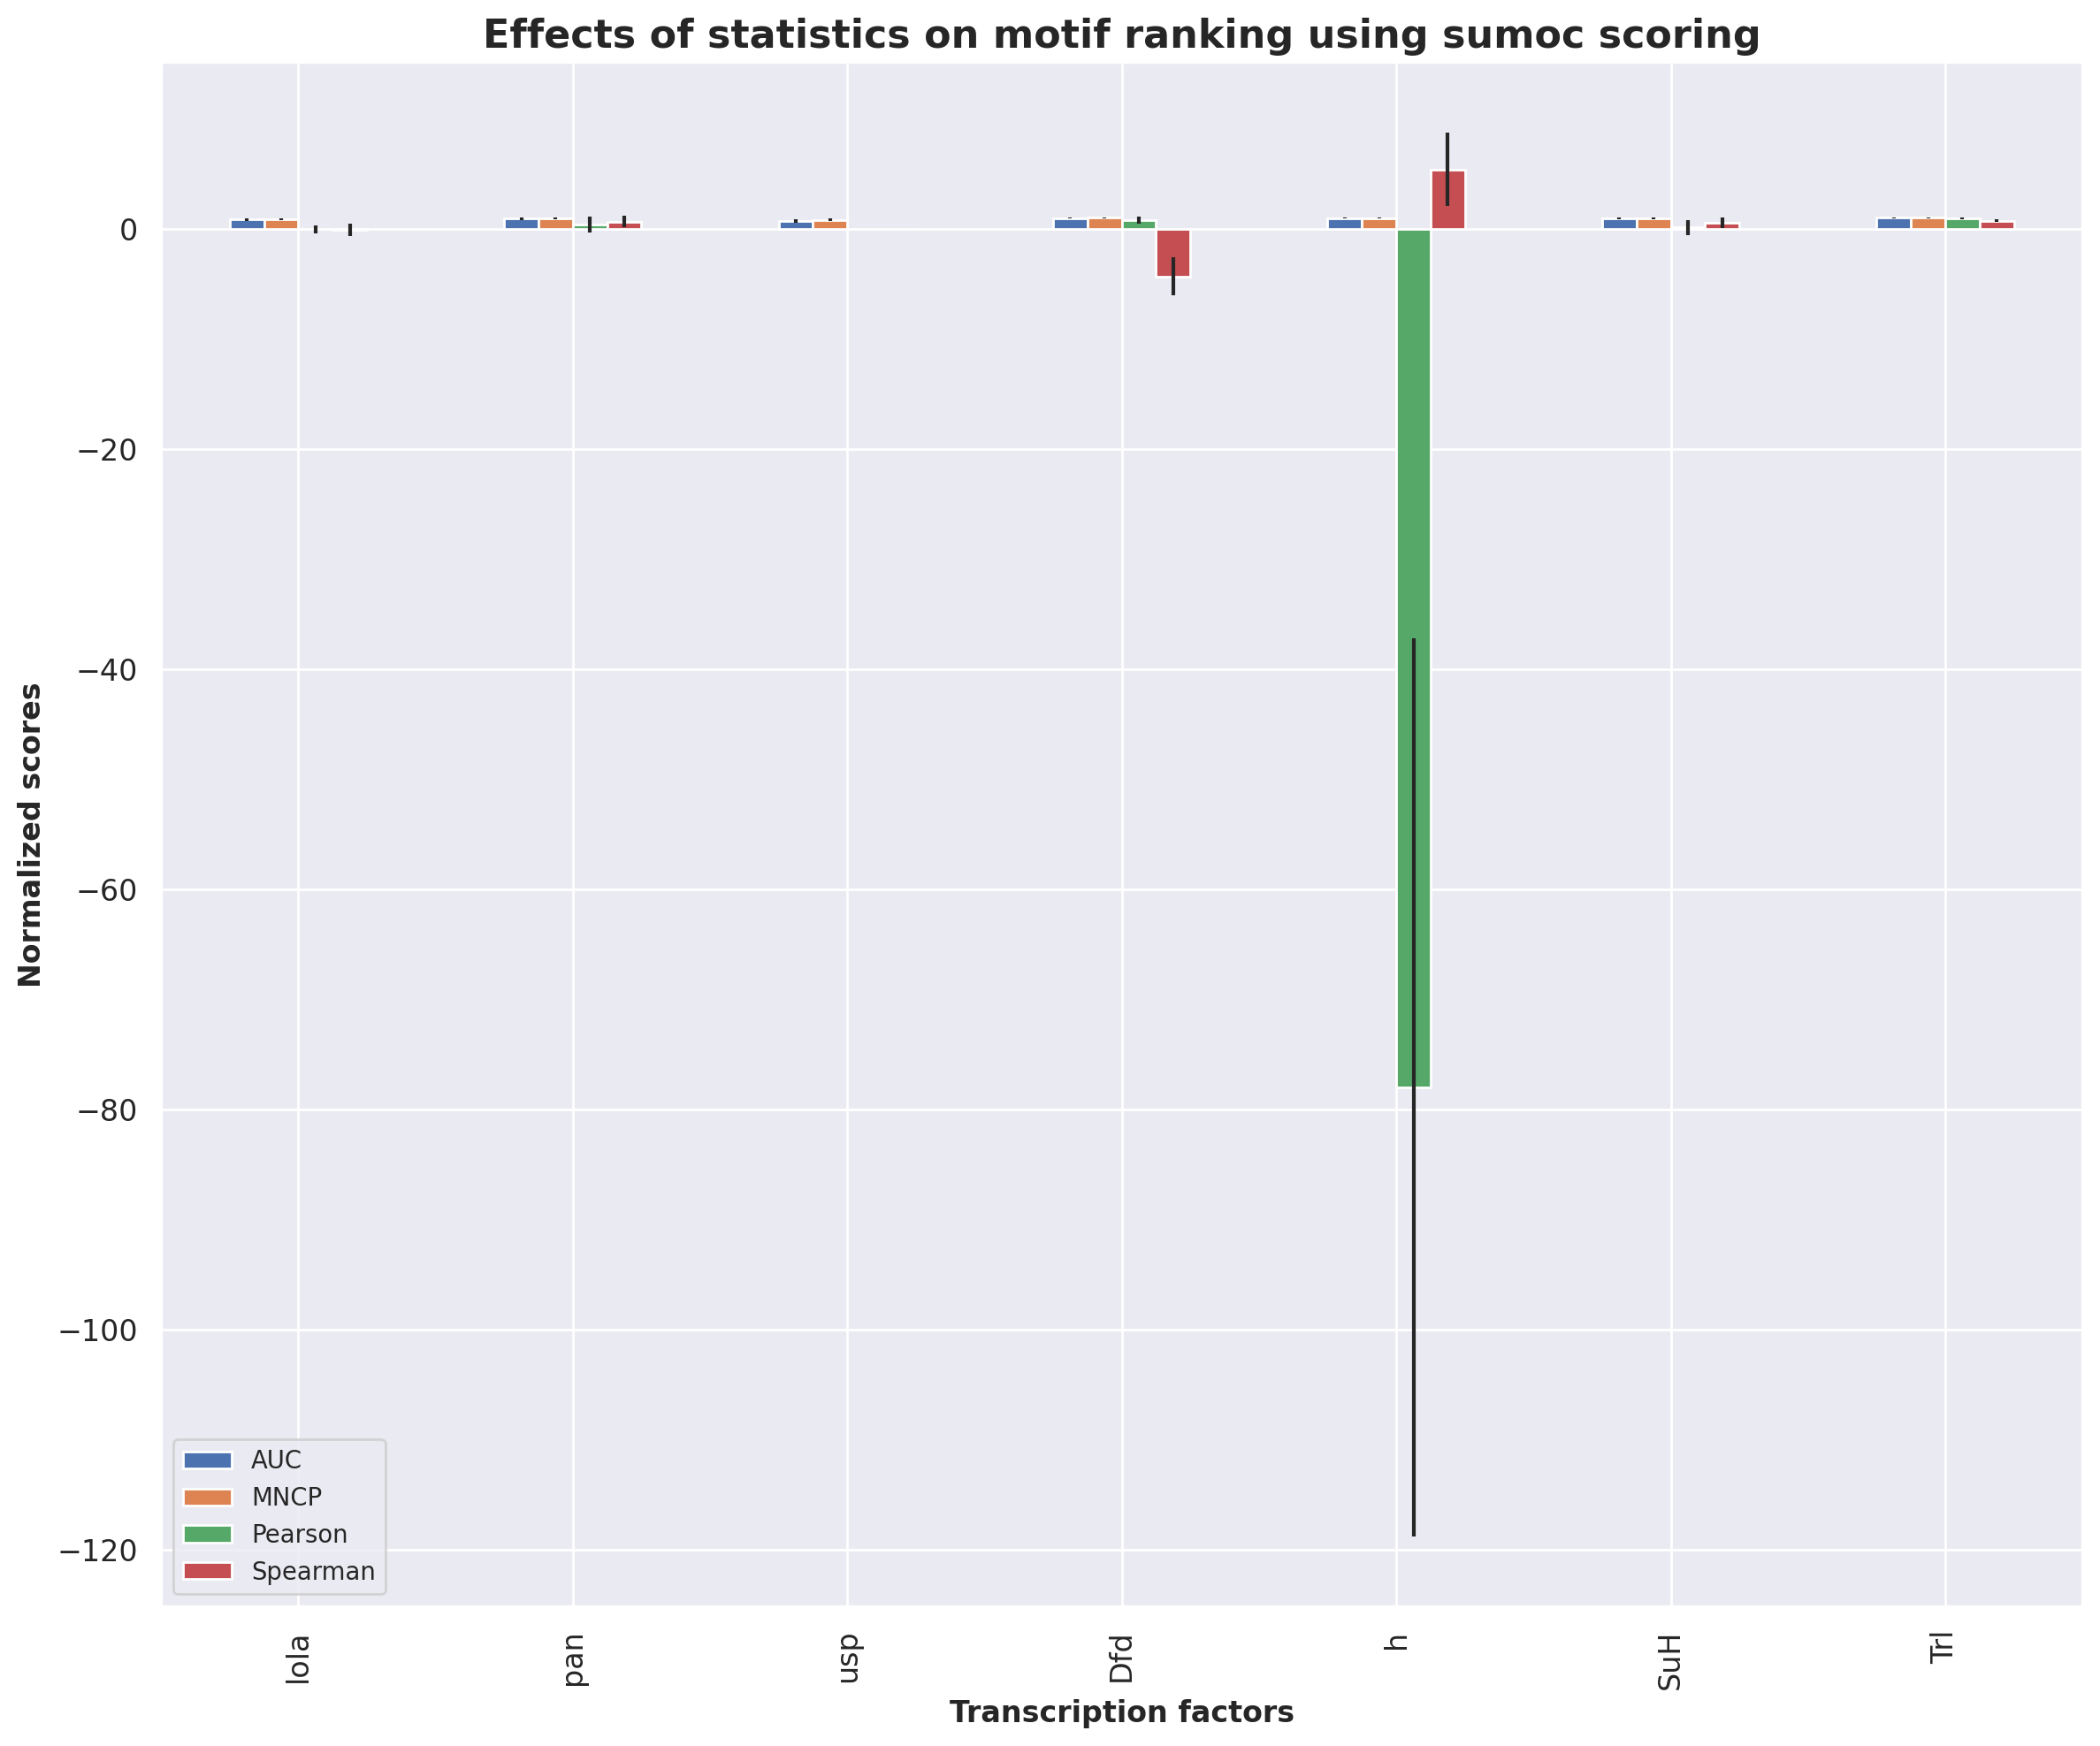

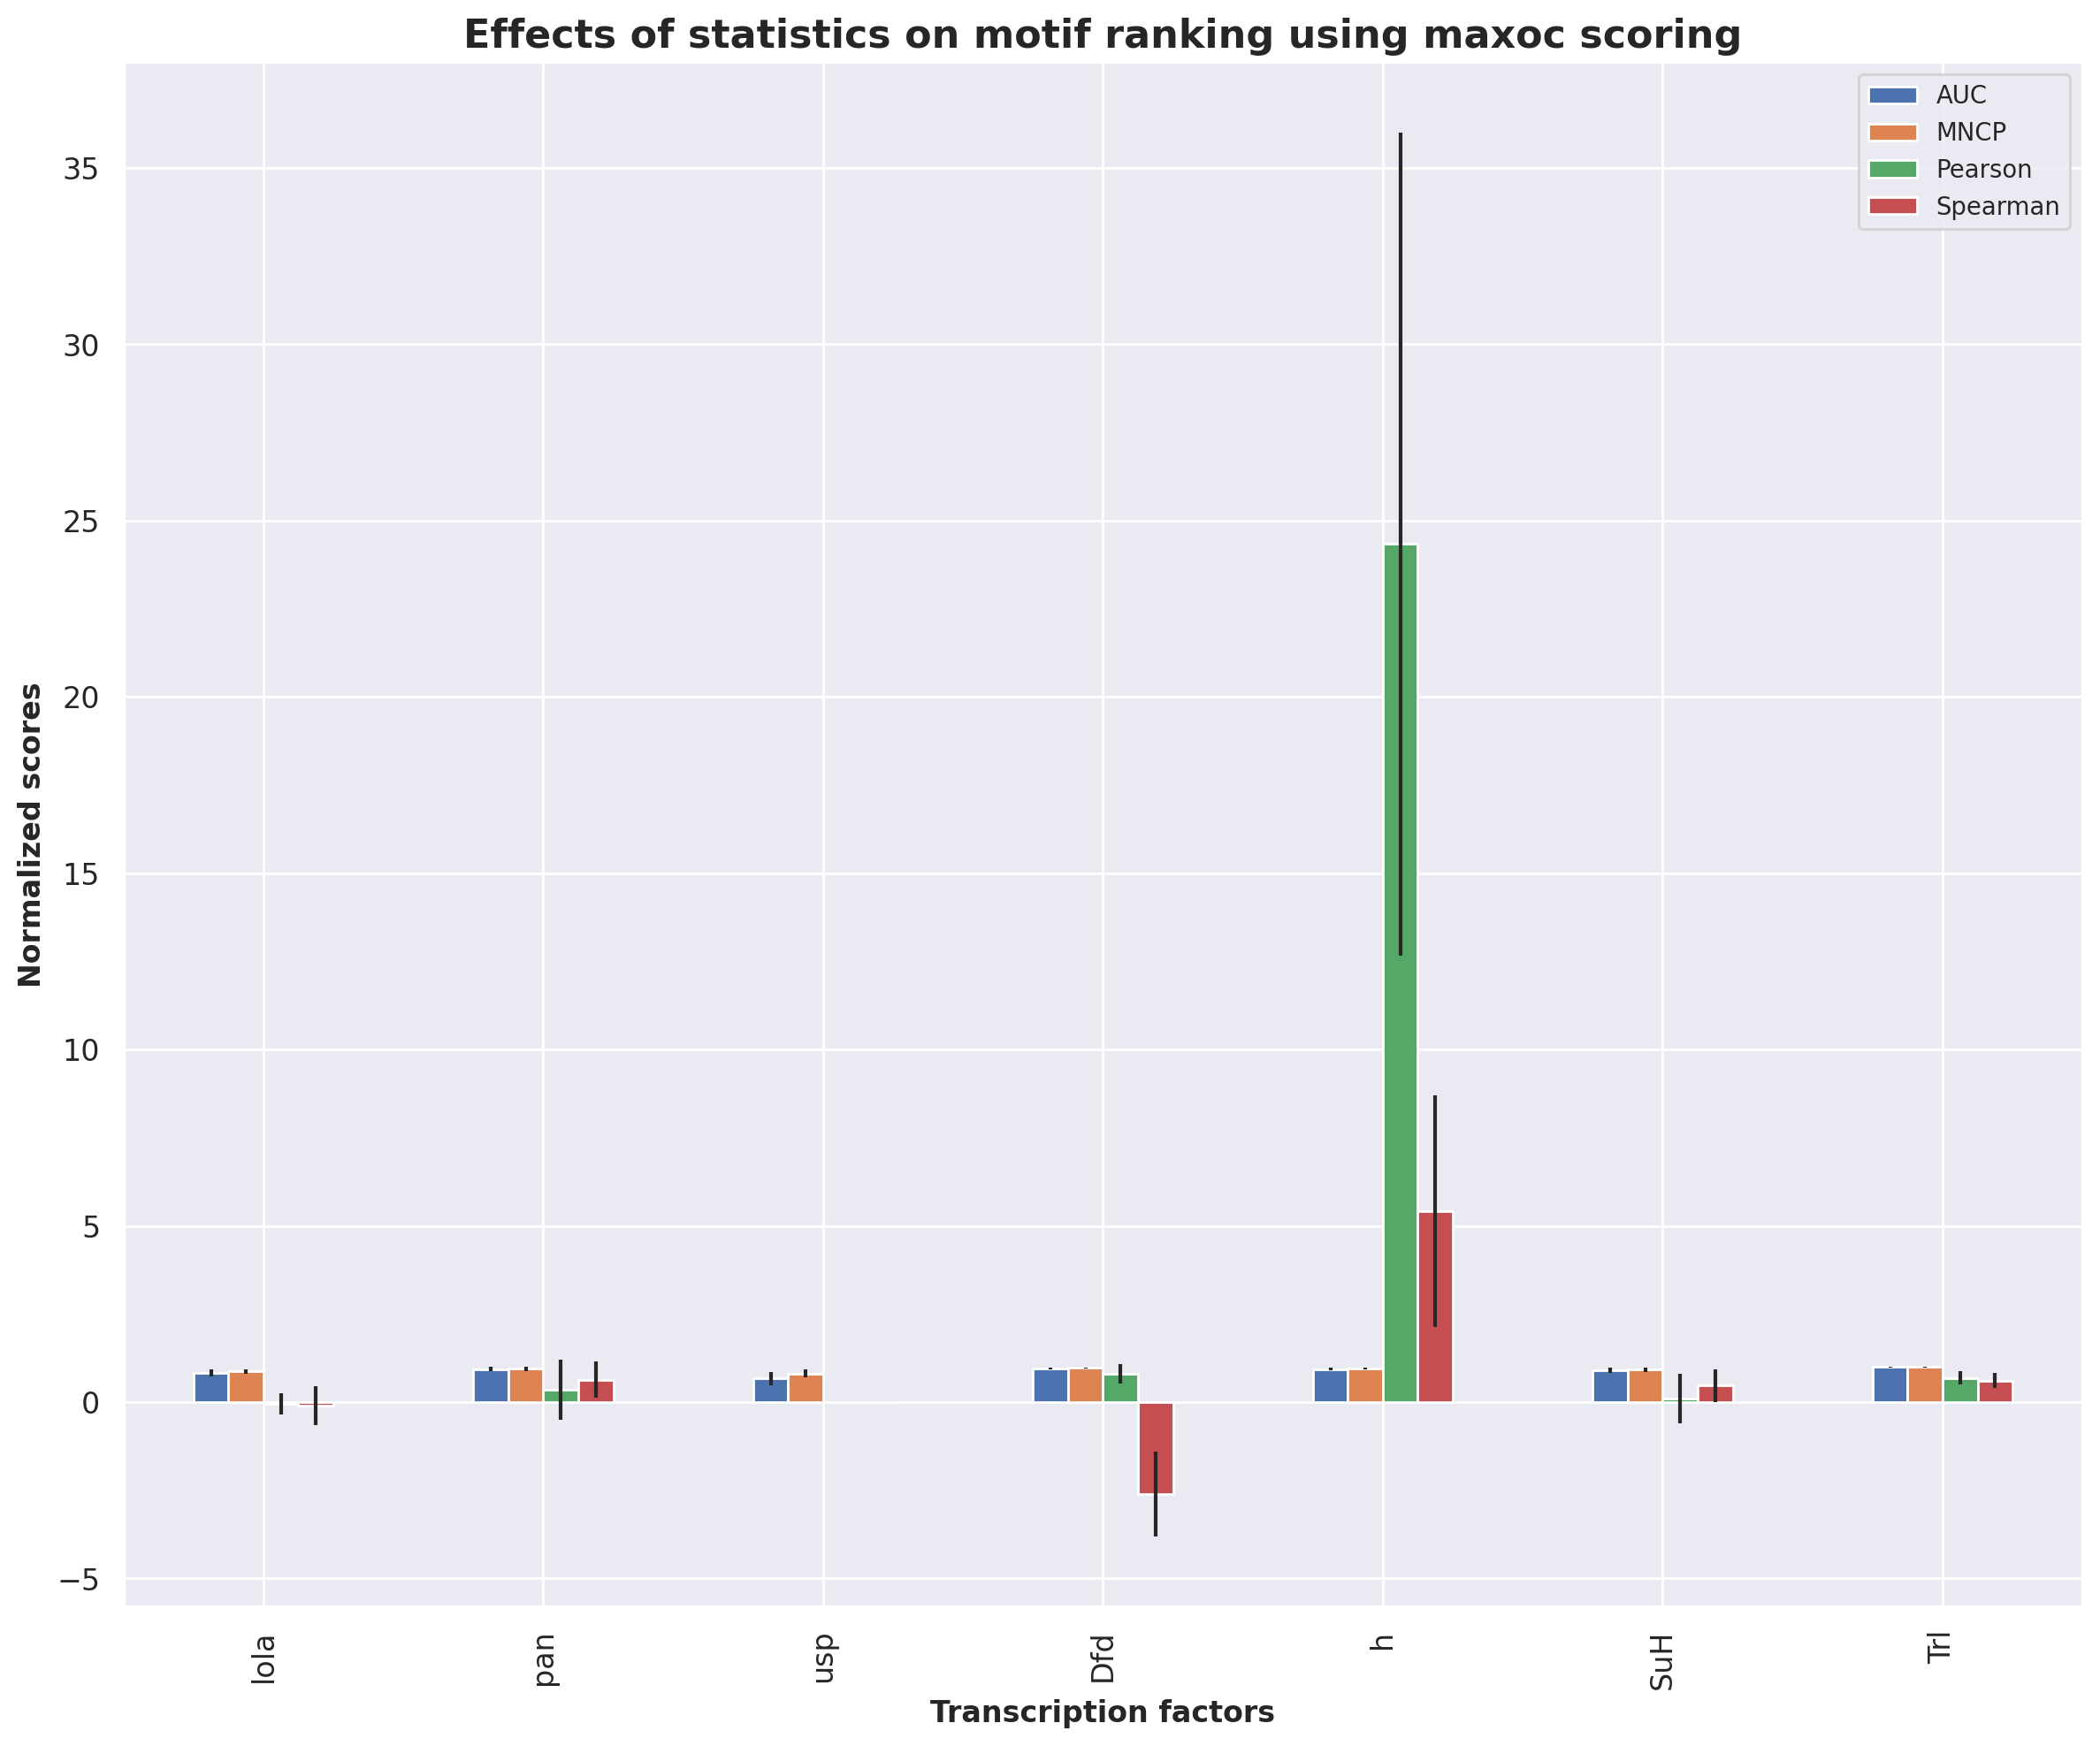

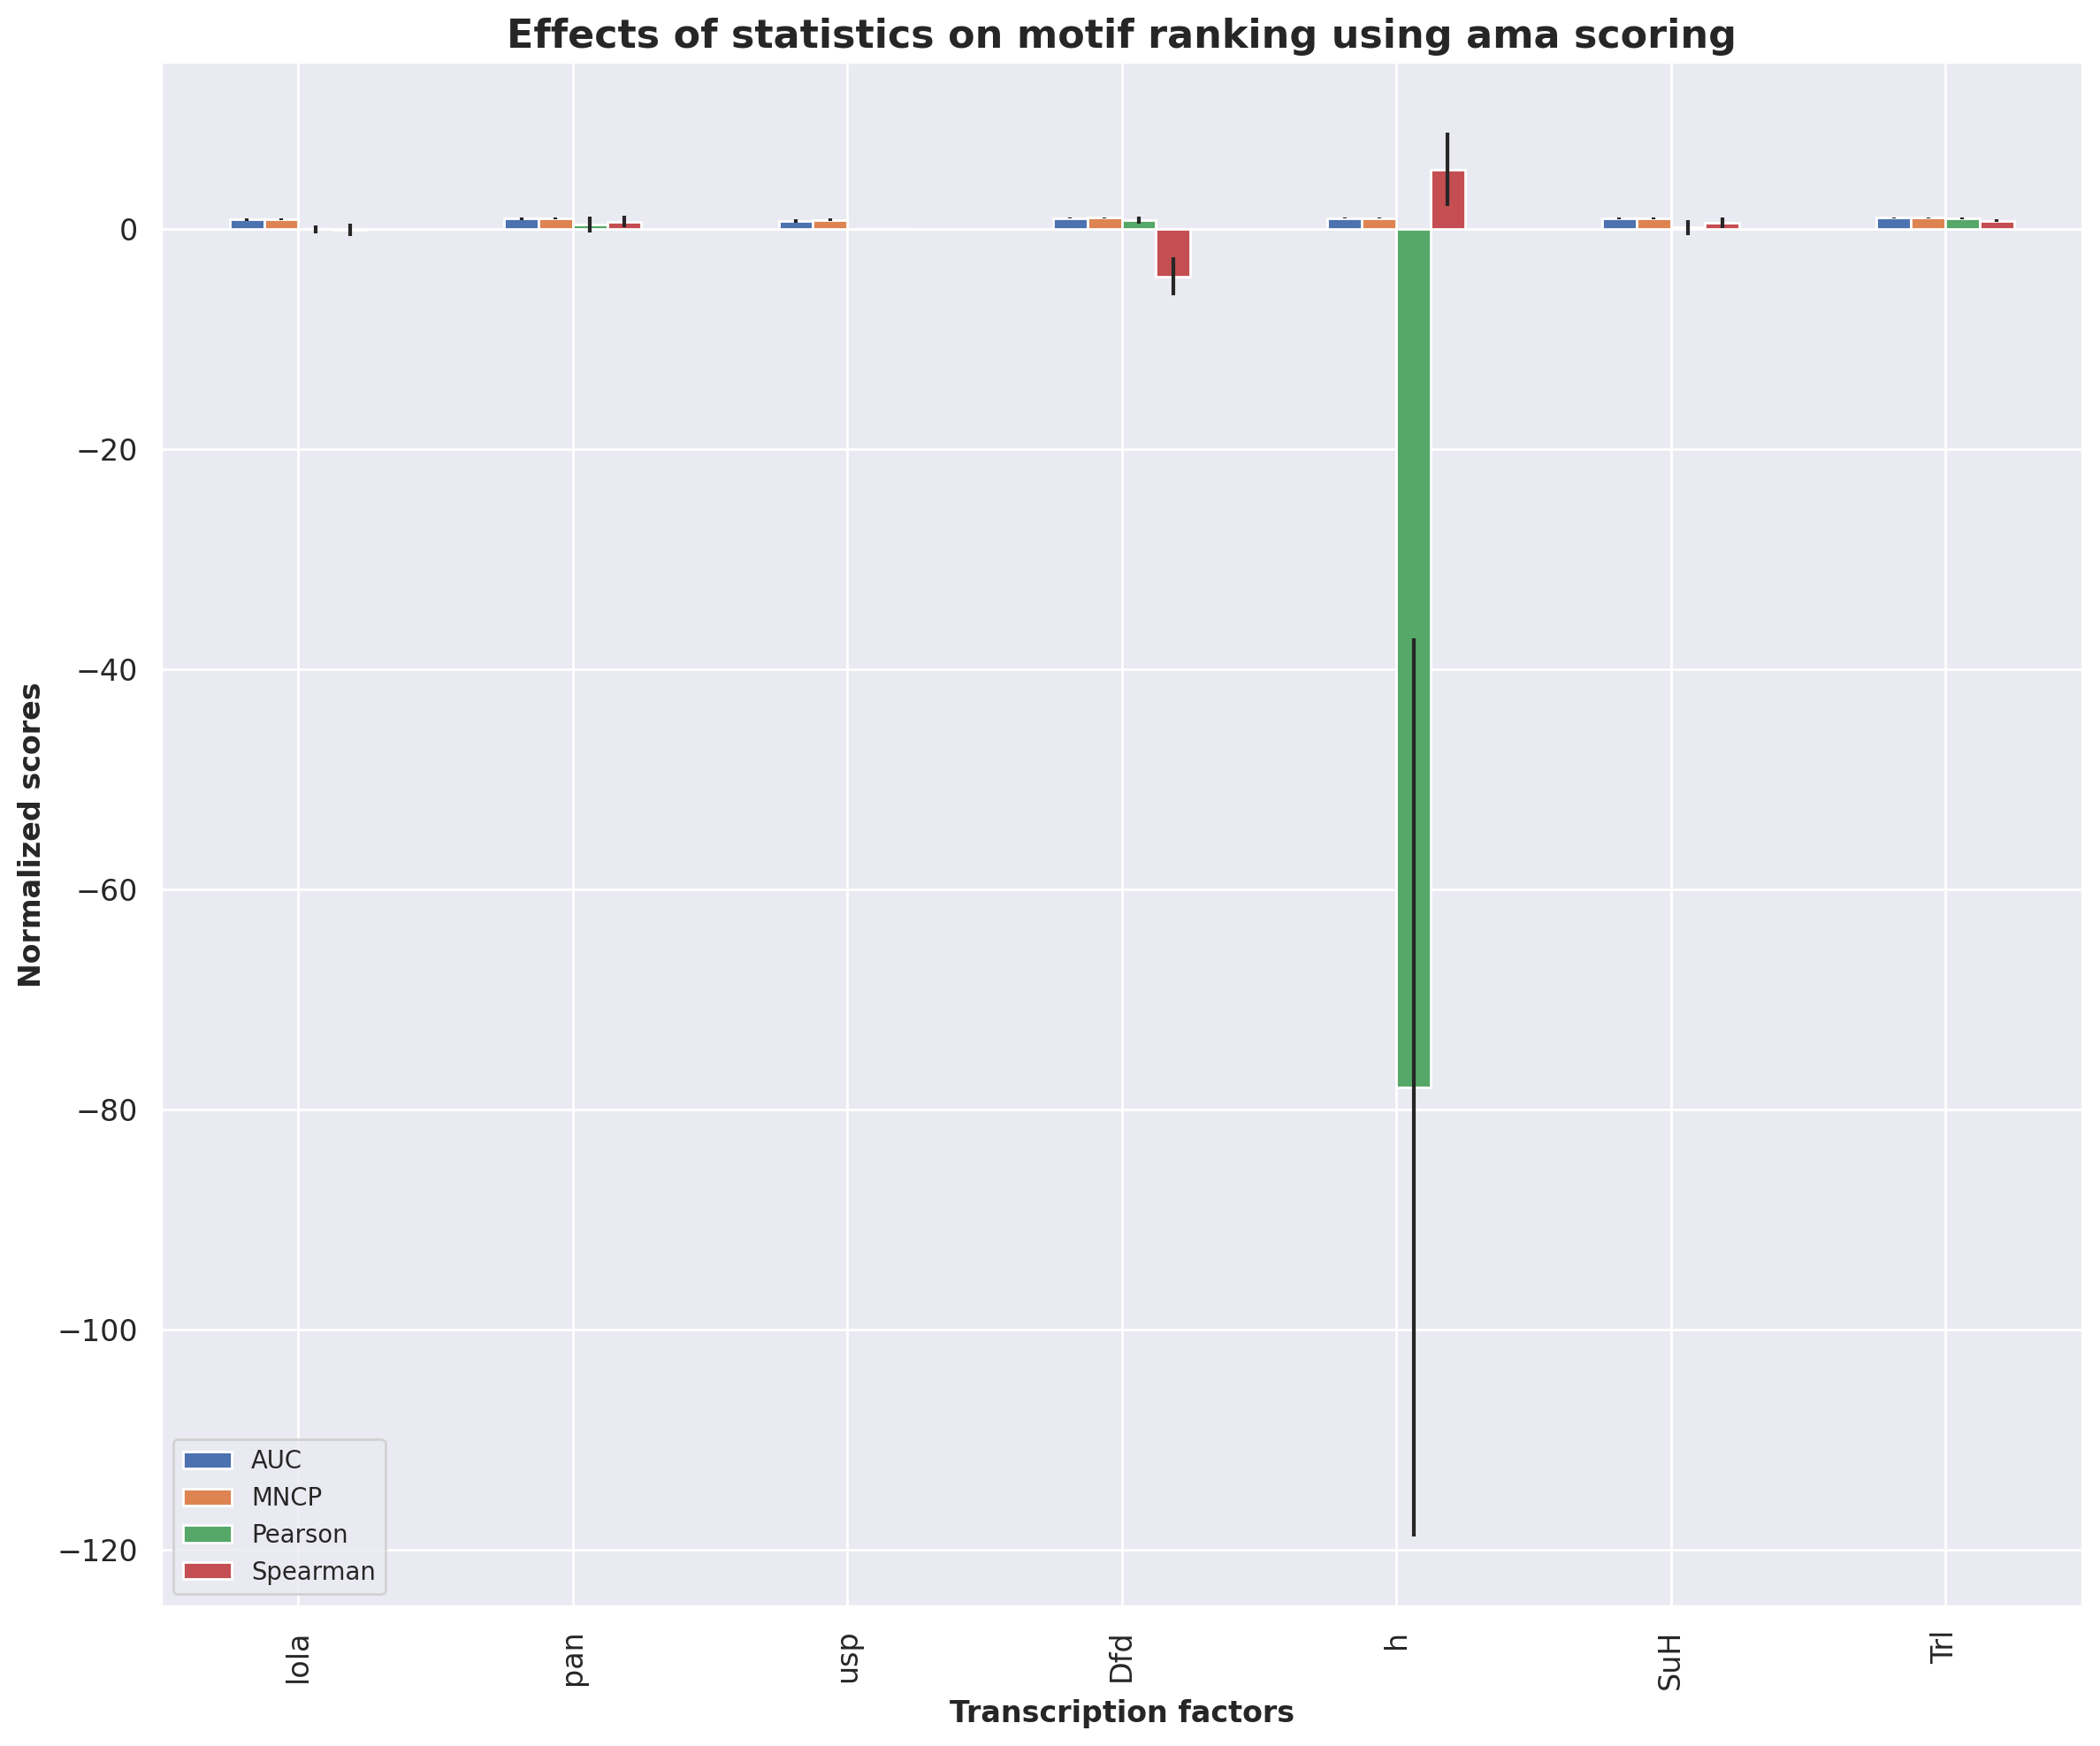

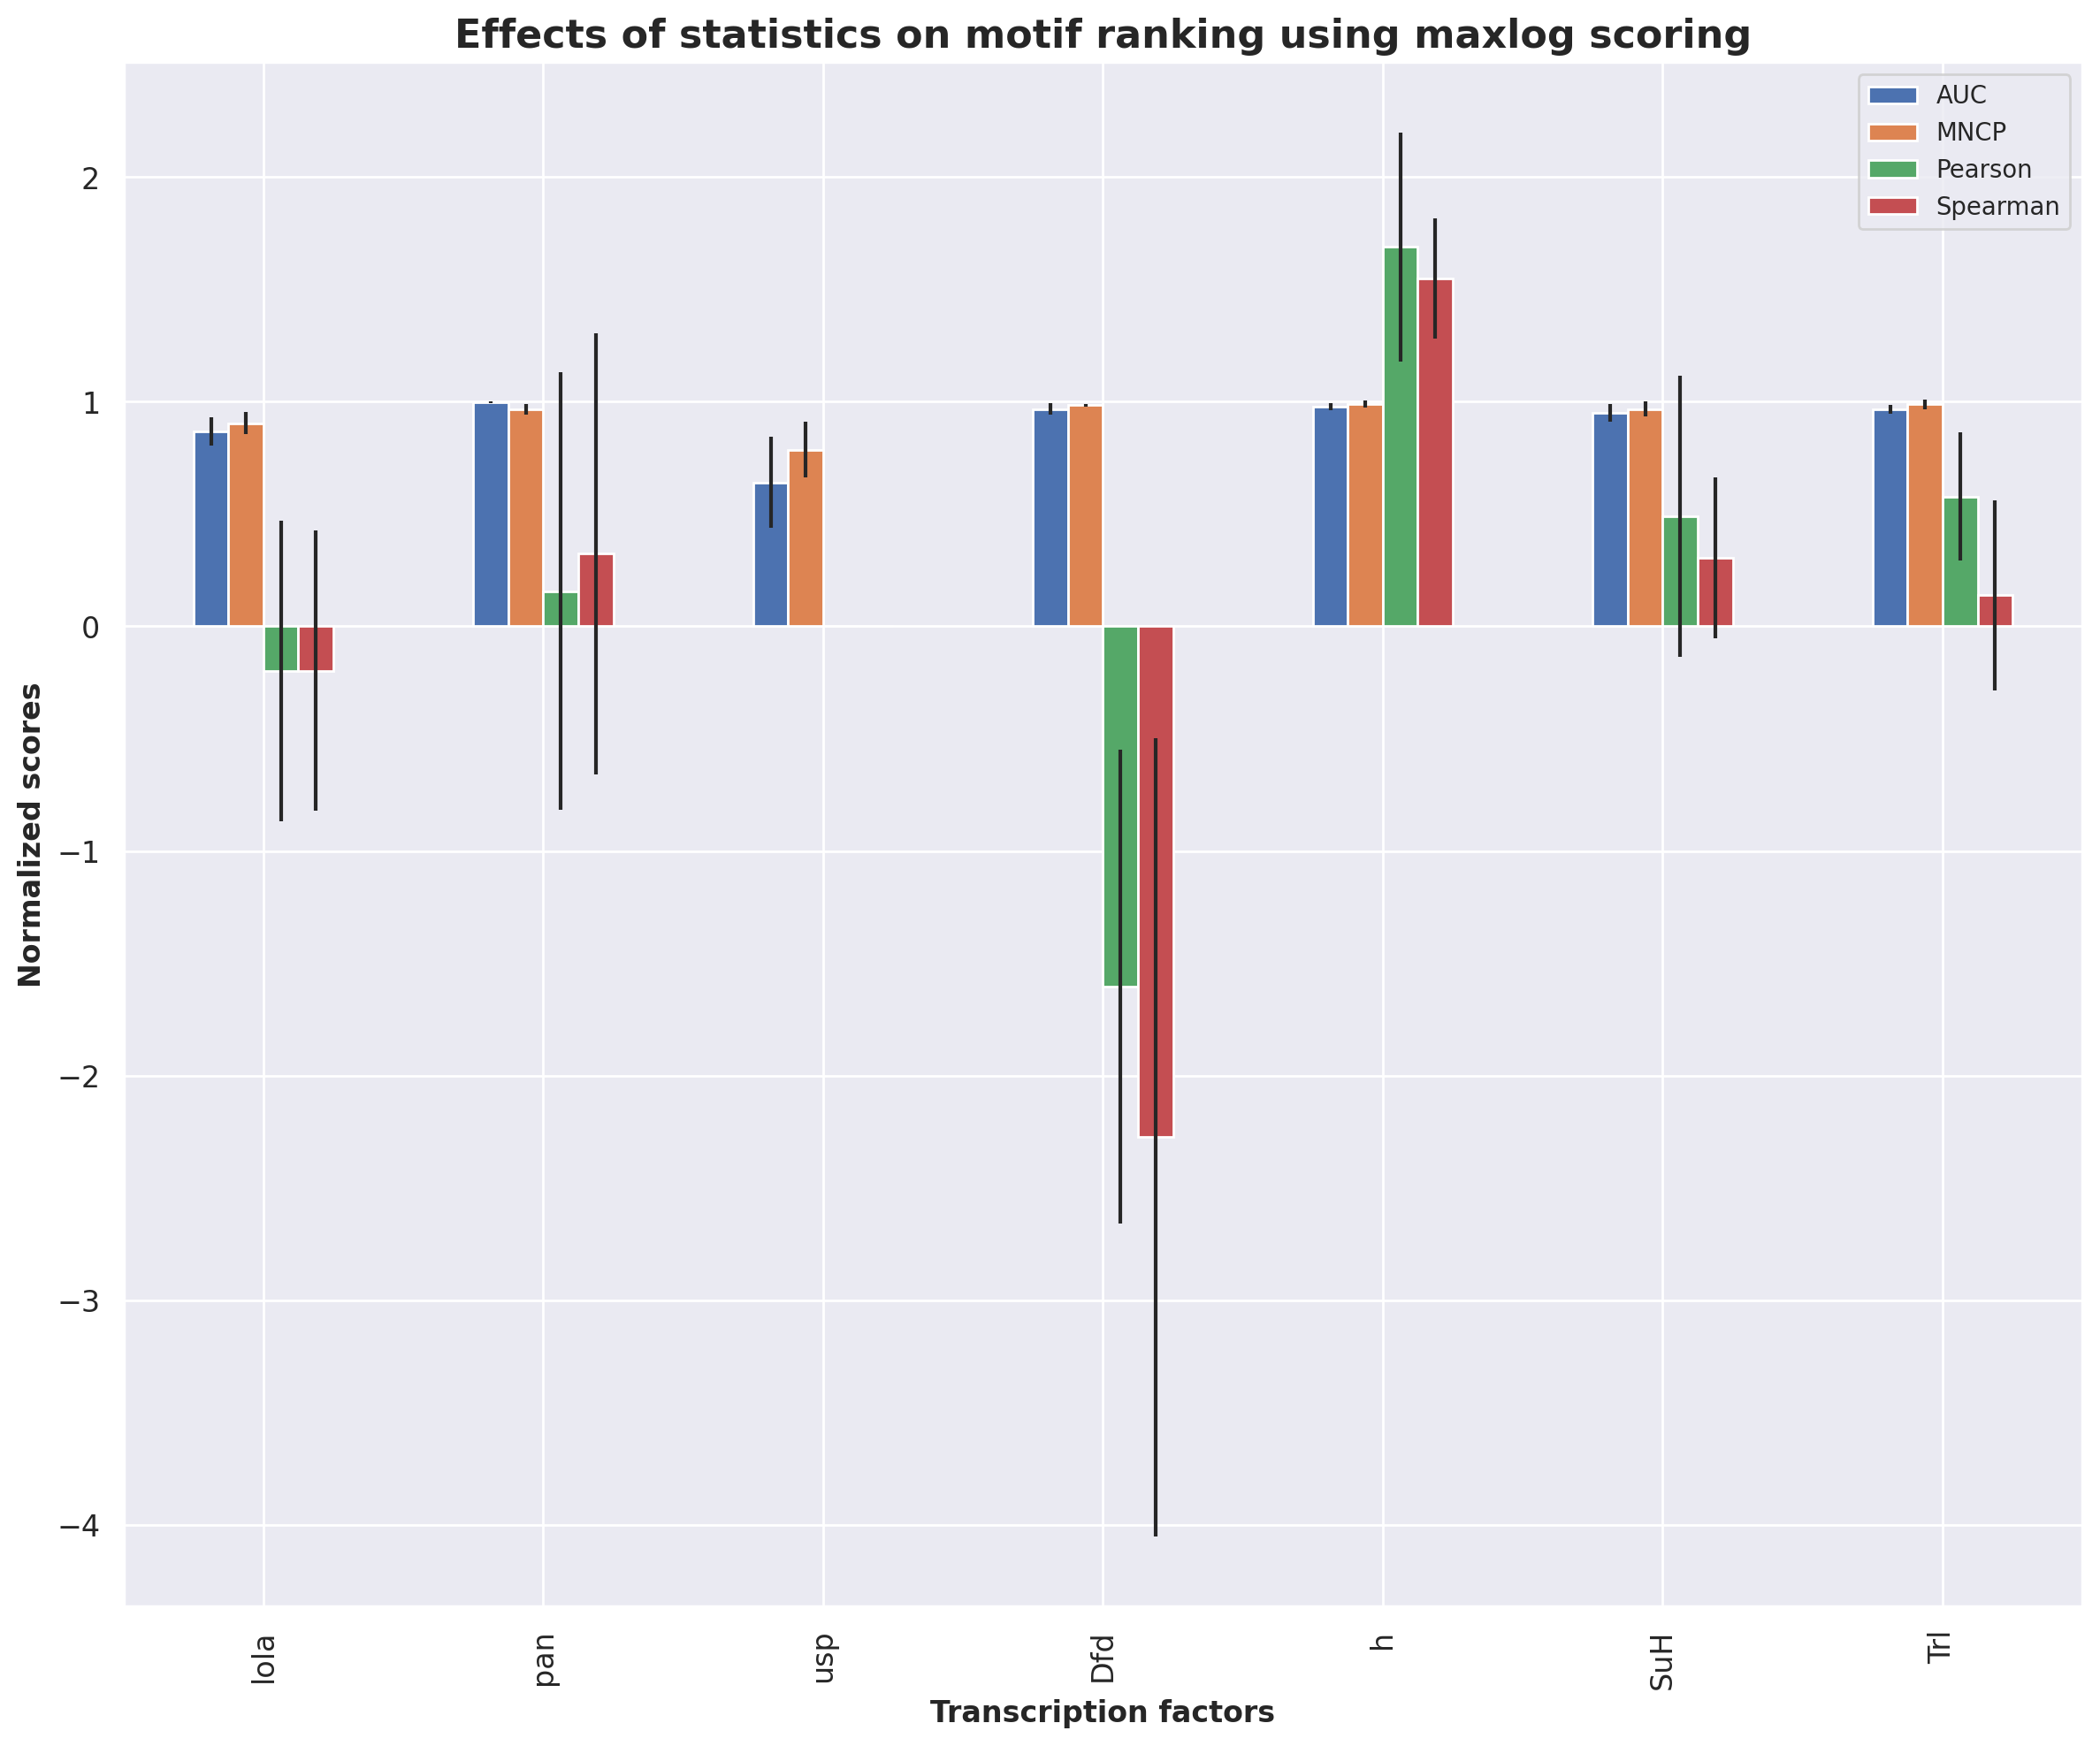

In [116]:
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
score_list = ["energy", "gomer", "sumlog", "sumoc",	"maxoc", "ama", "maxlog"]

for score in score_list:
    #print(f"Effects of statistics on motif ranking using {score} scoring")

    tf = tf_list[0]
    chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
    chip = chip/chip.max()
    chip_std = chip.std().to_frame(name=tf).T
    chip_mean = np.mean(chip).to_frame(name=tf)
    chip_mean_test = chip_mean.T
    rank_sum = ranksums(chip['AUC'],chip['Spearman'])[1] # compute wilcoxon rank-sum test

    for tf in tf_list[1:]:
        chip = pd.read_table('Results/%s/%s.%s' % (tf, tf, score), index_col='Motif')
        chip = chip/chip.max()
        #print tf
        rank_sum += ranksums(chip['AUC'],chip['Spearman'])[1]
        chip_s = chip.std().to_frame(name=tf)
        chip_std = chip_std.append(chip_s.T)
        chip_mean = np.mean(chip).to_frame(name=tf)

        chip_mean_test = chip_mean_test.append(chip_mean.T)
    
    
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot()

    chip_mean_test.plot(kind='bar',yerr=chip_std, ax= ax,fontsize=12, figsize=(12,10))
    
    ax.set_title((f"Effects of statistics on motif ranking using {score} scoring"),fontdict={'fontsize': 16, 'fontweight': 'bold'} )
    ax.set_xlabel("Transcription factors",fontdict={'fontsize': 12, 'fontweight': 'semibold'})
    ax.set_ylabel("Normalized scores", fontdict={'fontsize': 12, 'fontweight': 'semibold'})
   
    fig.tight_layout()

    #fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')


# Effects of scoring AUC

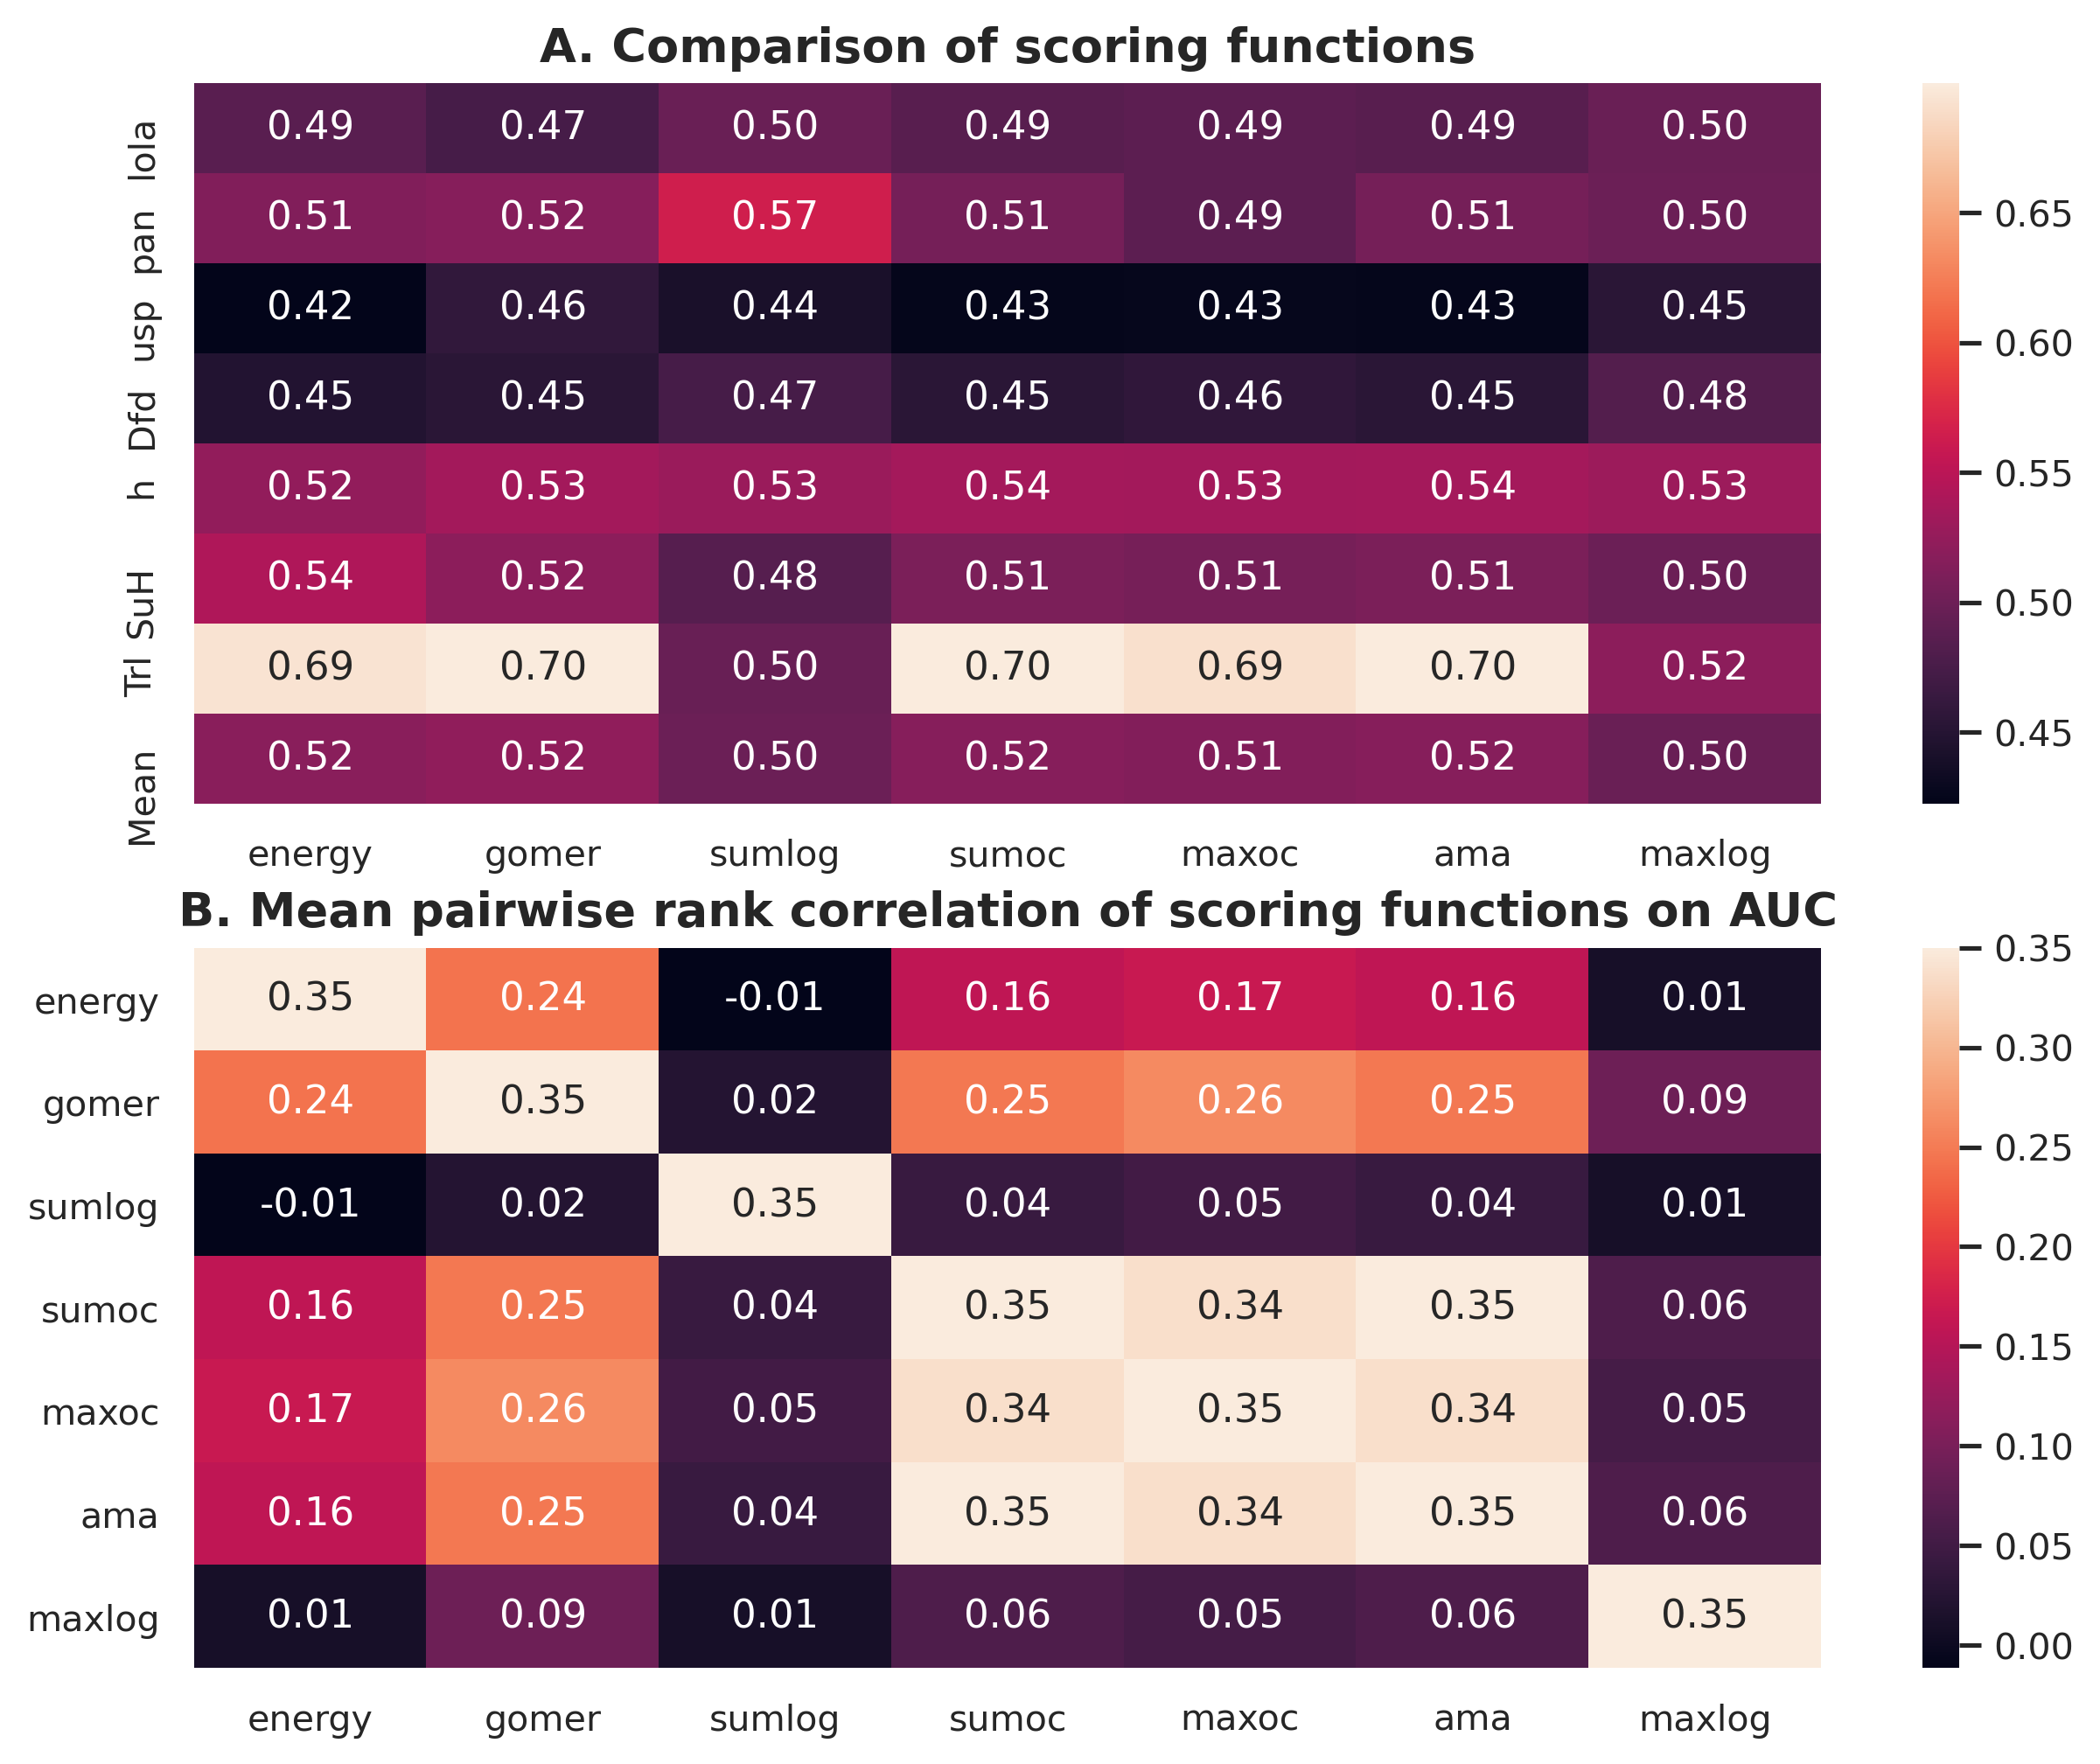

In [111]:
import seaborn as sns
stat='auc'
tf_list = ["lola", "pan", "usp", "Dfd", "h", "SuH", "Trl"]
#fig, ax = plt.subplots()
sns.set(font_scale=0.9)
fig = plt.figure(figsize=(10, 8),dpi=300)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

scores = "energy	gomer	sumlog	sumoc	maxoc   ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A. Comparison of scoring functions",fontdict={'fontsize': 13, 'fontweight':'demibold','ma':'center'})



tf = tf_list[0]
stat = 'auc'
mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

for tf in tf_list[1:]:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B. Mean pairwise rank correlation of scoring functions on AUC",
             fontdict={'fontsize': 13, 'fontweight':'semibold','ma':'center'})
f=plt.gcf()
#f.savefig('../Figures/Effect_of_scoring_auc_new.pdf', bbox_inches='tight')

# Effects of scoring MNCP

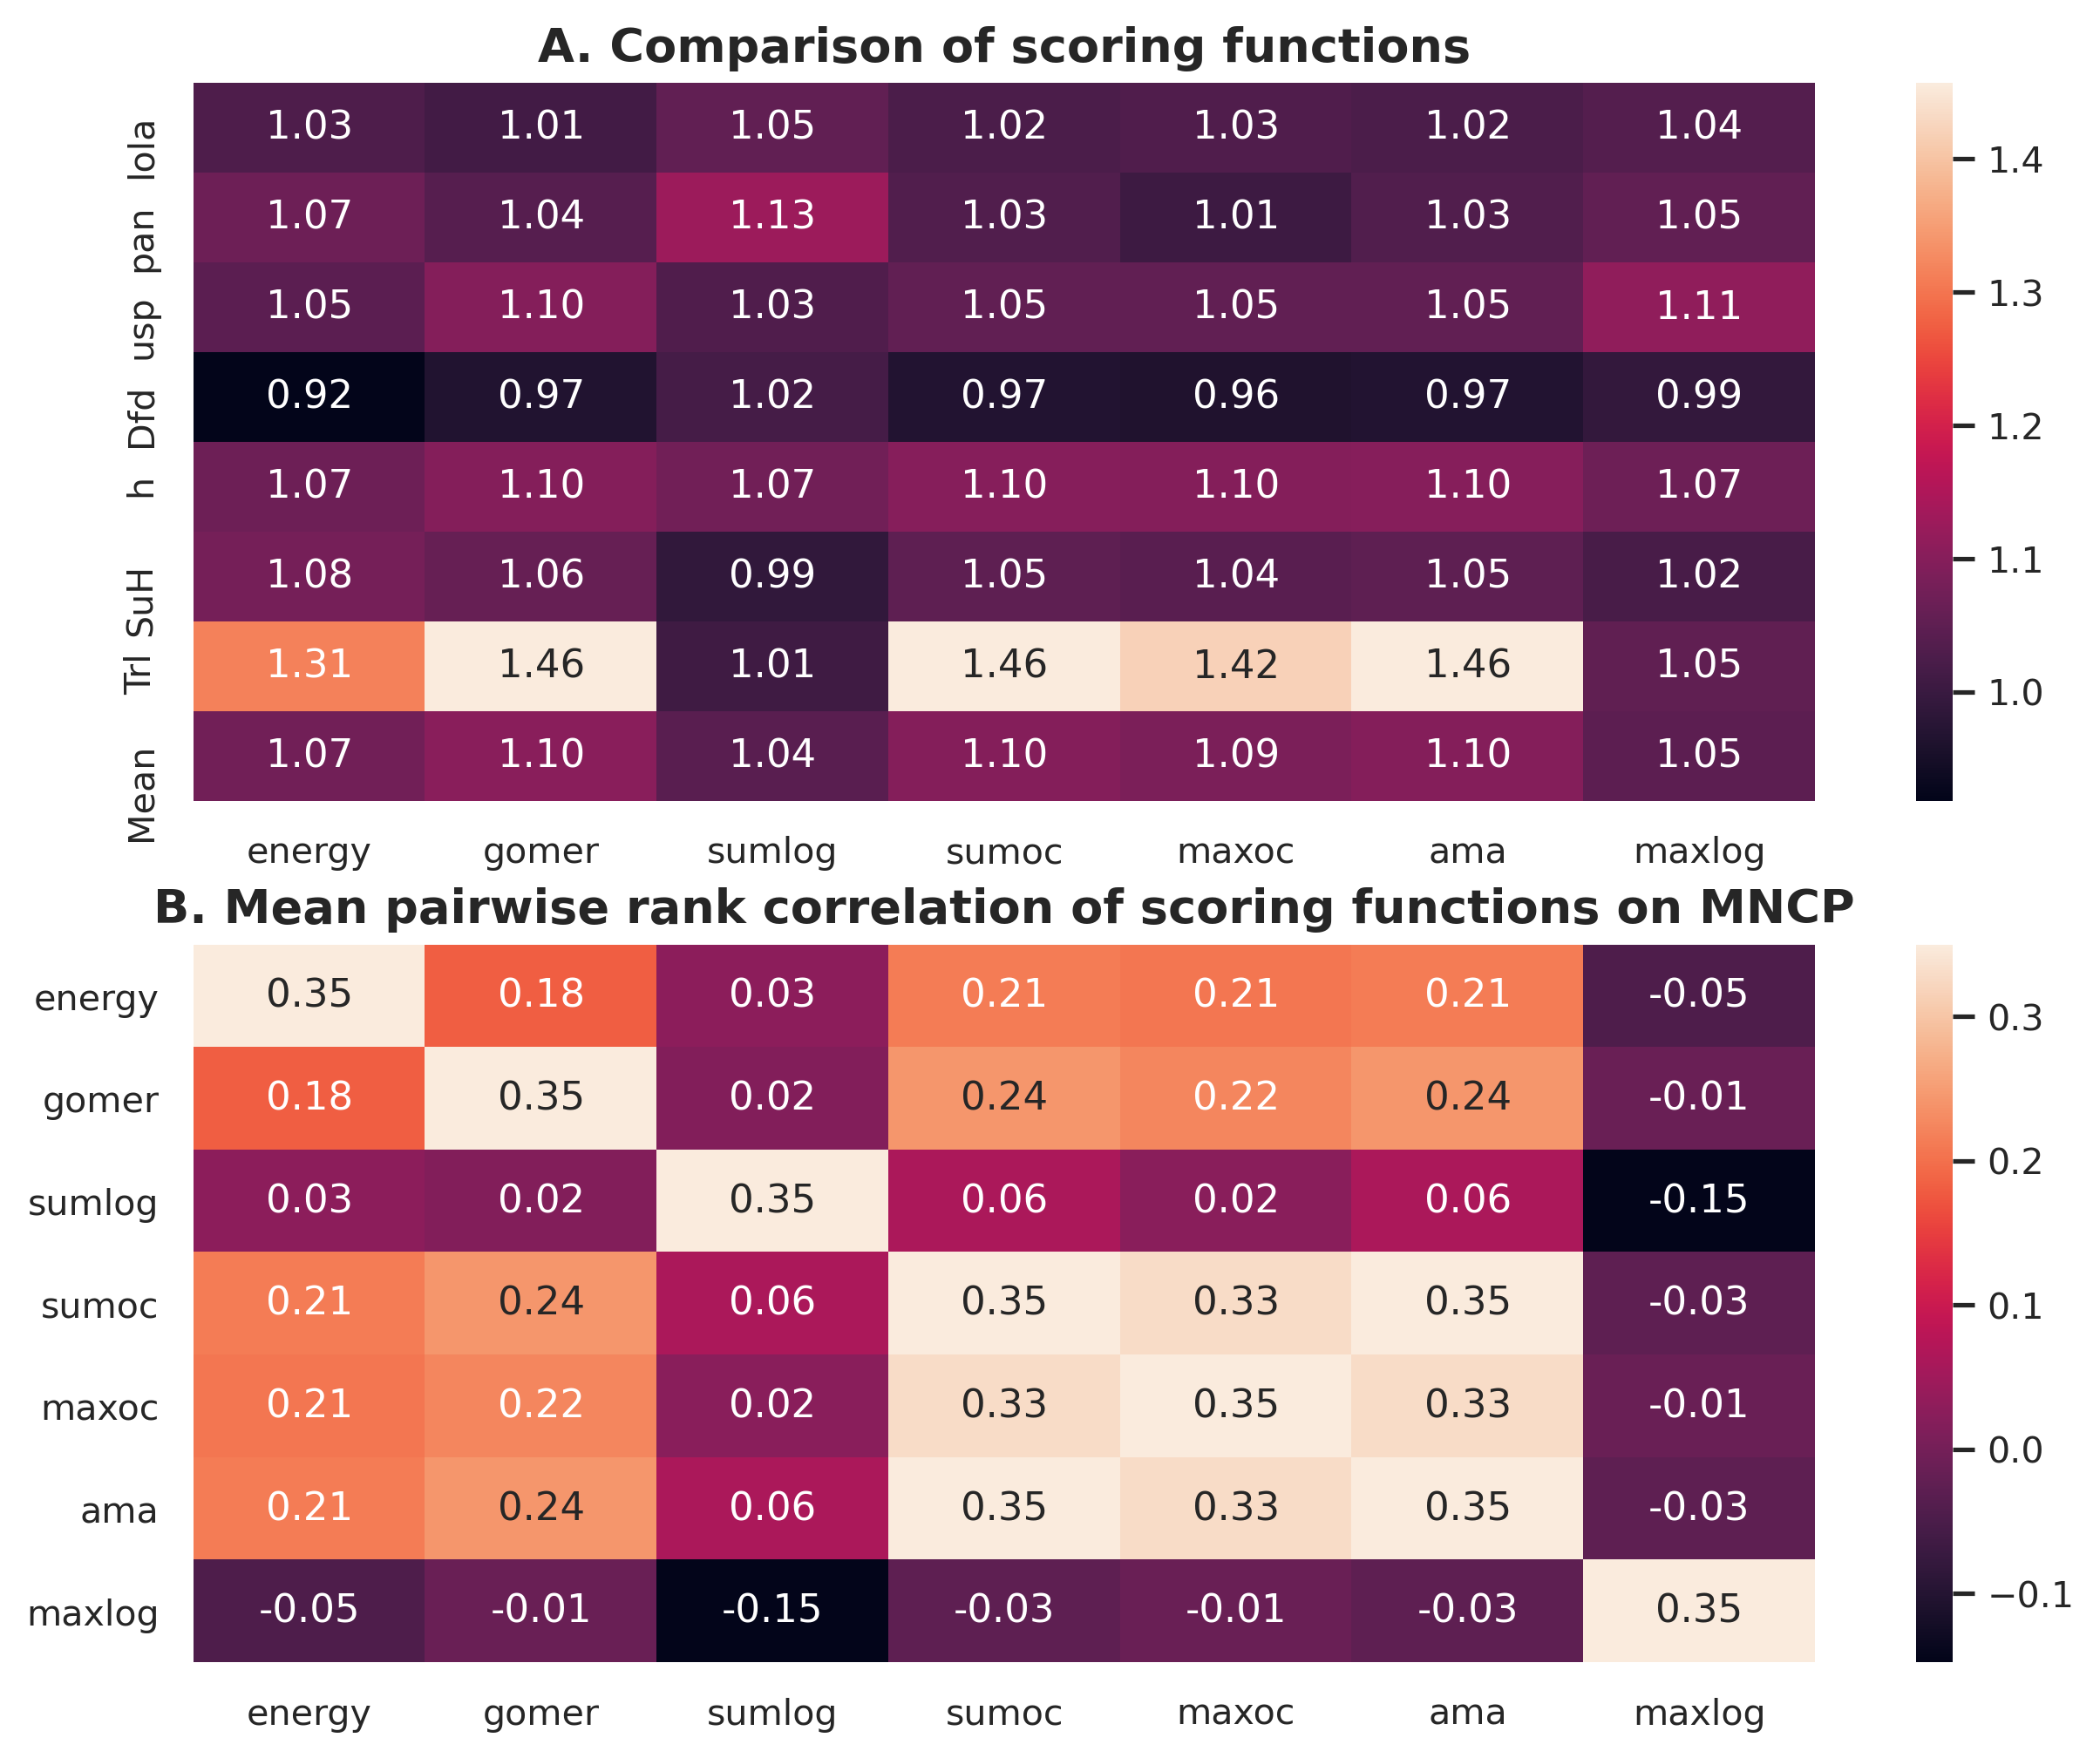

In [113]:
stat='mncp'


sns.set(font_scale=0.9)
fig = plt.figure(figsize=(10, 8),dpi=300)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("A. Comparison of scoring functions",fontdict={'fontsize': 13, 'fontweight':'demibold','ma':'center'})

tf = tf_list[0]
stat = 'mncp'
mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

for tf in tf_list[1:]:
    mot_score =pd.read_table("Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/20, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B. Mean pairwise rank correlation of scoring functions on MNCP",
             fontdict={'fontsize': 13, 'fontweight':'demibold','ma':'center'})

f=plt.gcf()
#f.savefig('../Figures/Effect_of_scoring_mncp_new.pdf', bbox_inches='tight')



In [114]:
sns.heatmap?

Signature:
sns.heatmap(
    data,
    vmin=None,
    vmax=None,
    cmap=None,
    center=None,
    robust=False,
    annot=None,
    fmt='.2g',
    annot_kws=None,
    linewidths=0,
    linecolor='white',
    cbar=True,
    cbar_kws=None,
    cbar_ax=None,
    square=False,
    xticklabels='auto',
    yticklabels='auto',
    mask=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot rectangular data as a color-encoded matrix.

This is an Axes-level function and will draw the heatmap into the
currently-active Axes if none is provided to the ``ax`` argument.  Part of
this Axes space will be taken and used to plot a colormap, unless ``cbar``
is False or a separate Axes is provided to ``cbar_ax``.

Parameters
----------
data : rectangular dataset
    2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
    is provided, the index/column information will be used to label the
    columns and rows.
vmin, vmax : floats, optional
    Values to anchor the colormap, otherwise they a